In [1]:
import scanpy as sc
import bbknn

# Load the data
adata = sc.read_h5ad('/mnt/data/melhajjar/ipf_metadata_analysis/human_cell_atlas/lung_core_HLCA.h5ad', backed='r')
adata = adata[::40, :]  # Subset to reduce size
adata = adata.to_memory()  # Load data fully into memory

/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 27957 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


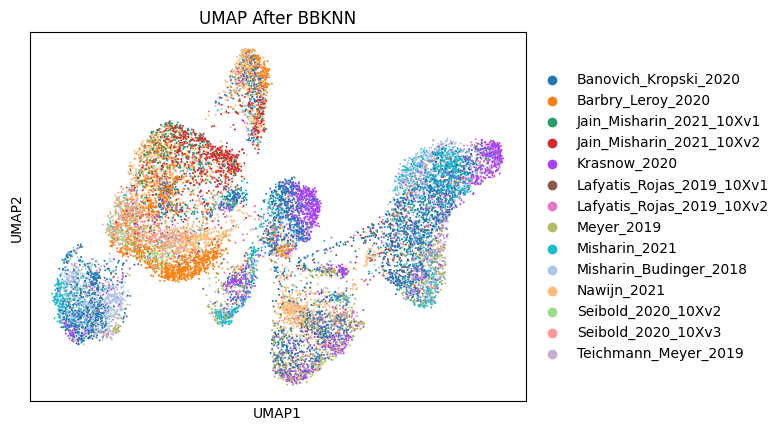

In [2]:
# With BBKNN
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
test = adata.copy()
bbknn.bbknn(adata, batch_key='dataset')  # Batch correction
sc.tl.umap(adata)
sc.pl.umap(adata, color='dataset', title='UMAP After BBKNN')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [3]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [4]:
import re, pandas as pd
import mygene
mg = mygene.MyGeneInfo()

# strip version (ENSG... .xx)
ens = pd.Index(adata.var_names).str.replace(r'\.\d+$','', regex=True)

df = mg.querymany(ens.tolist(),
                  scopes='ensembl.gene', fields='symbol',
                  species='human', as_dataframe=True)

# keep first match per queried ENSG
df = df[~df.index.duplicated(keep='first')]

adata.var['ensembl_id'] = ens
adata.var['symbol'] = ens.map(df['symbol'])
adata.var_names = adata.var['symbol'].fillna(adata.var['ensembl_id'])
adata.var_names_make_unique()


11 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000227110', 2), ('ENSG00000228044', 2), ('ENSG00000234352', 2), ('E
356 input query terms found no hit:	['ENSG00000131484', 'ENSG00000132832', 'ENSG00000146521', 'ENSG00000168078', 'ENSG00000176659', 'ENS


In [5]:
# ============================================
# PLS MODEL (numeric ages, processed adata) + VISUALS + PROGRESS (FAST)
# ============================================

import os, warnings, gc, re, time, contextlib
warnings.filterwarnings("ignore")

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy import stats
from scipy.stats import kendalltau, spearmanr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from statsmodels.stats.multitest import multipletests

# Try tqdm for progress bars (optional)
try:
    from tqdm.auto import tqdm
    _HAVE_TQDM = True
except Exception:
    _HAVE_TQDM = False
    def tqdm(x, **kw): return x  # no-op fallback

# -------------------------
# Config
# -------------------------
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

CELLTYPE_COL = "original_ann_level_4"          # adjust if needed
AGE_FIELD    = "age_or_mean_of_age_range"      # numeric ages already in obs

TARGET_CELLTYPES = [
    "Alveolar macrophages",
    "Classical monocytes",
    "Intermediate monocytes",
    "Interstitial macrophages",
    "Macrophages MARCO-",
    "Macrophages SPP1 high",
    "Non-classical monocytes",
]

# Speed/quality knobs
HVGS_N             = 2000     # number of highly variable genes to keep
N_COMPONENTS_MAX   = 20       # hard max; we also cap with MAX_COMP_CAP below
MAX_COMP_CAP       = 12       # extra safety cap to speed CV
STAB_N_RUNS        = 25       # stability iterations
STAB_SAMPLE_FRAC   = 0.8      # sub-sample fraction for stability
STAB_MIN_FREQ      = 0.3      # threshold for stable genes
N_PERM             = 50       # <-- use 50 while iterating; bump to 200 for final runs
N_PLOT_GENES       = 50
TOP_LINES          = 10
FIG_DPI            = 300
RANDOM_SEED        = 0
SCATTER_POINT_SIZE = 56
rng = np.random.RandomState(RANDOM_SEED)

# -------------------------
# Utilities / Helpers
# -------------------------
@contextlib.contextmanager
def timer(msg):
    t0 = time.perf_counter()
    print(f"\n▶️ {msg} ...", flush=True)
    try:
        yield
    finally:
        dt = time.perf_counter() - t0
        print(f"✅ done: {msg} ({dt:.2f}s)", flush=True)

def _canon(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).lower().strip())

CANON_TARGETS = {_canon(x): x for x in TARGET_CELLTYPES}
def is_target_celltype(name: str) -> bool:
    return _canon(name) in CANON_TARGETS

def cv_r2_pls(Xz, y, n_comp, n_splits=5):
    kf = KFold(n_splits=min(n_splits, len(y)), shuffle=True, random_state=RANDOM_SEED)
    scores = []
    for tr, te in kf.split(Xz):
        pls = PLSRegression(n_components=n_comp, scale=False)
        pls.fit(Xz[tr], y[tr])
        yhat = pls.predict(Xz[te]).ravel()
        ss_res = np.sum((y[te] - yhat)**2)
        ss_tot = np.sum((y[te] - np.mean(y[tr]))**2)
        scores.append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
    return float(np.nanmean(scores))

def perm_test_r2(Xz, y, n_comp, n_perm=200, n_splits=5, seed=0):
    rngp = np.random.RandomState(seed)
    obs = cv_r2_pls(Xz, y, n_comp, n_splits=n_splits)
    null = []
    it = tqdm(range(n_perm), disable=not _HAVE_TQDM, desc="Permutations")
    for _ in it:
        yperm = rngp.permutation(y)
        null.append(cv_r2_pls(Xz, yperm, n_comp, n_splits=n_splits))
    p = (1 + np.sum(np.array(null) >= obs)) / (1 + len(null))
    return obs, float(p)

def gene_age_kendall_fdr(X_mat, y, genes):
    """Kendall tau per gene + FDR (expects a smaller gene set for speed)."""
    taus, pvals = [], []
    it = tqdm(range(X_mat.shape[1]), disable=not _HAVE_TQDM, desc="Kendall τ (stable genes)")
    for j in it:
        t, p = kendalltau(y, X_mat[:, j], nan_policy="omit")
        taus.append(t); pvals.append(p)
    taus = np.array(taus); pvals = np.array(pvals)
    ok, p_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
    out = pd.DataFrame({"gene": genes, "kendall_tau": taus, "p_adj": p_adj, "pass_fdr": ok})
    return out.set_index("gene")

# -------------------------
# Plotting helpers
# -------------------------
def plot_component_heatmap(CxG: pd.DataFrame, title: str, out_path: str, vmin=None, vmax=None):
    n_c, n_g = CxG.shape
    fig_w = max(6, min(20, n_g * 0.4)); fig_h = max(4, min(18, n_c * 0.5))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(
        CxG.values, aspect="auto", interpolation="nearest",
        cmap="coolwarm", norm=TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
    )
    ax.set_xticks(np.arange(n_g)); ax.set_xticklabels(CxG.columns, rotation=90, fontsize=7)
    ax.set_yticks(np.arange(n_c)); ax.set_yticklabels(CxG.index, fontsize=9)
    ax.set_xlabel("Genes"); ax.set_ylabel("PLS component"); ax.set_title(title, fontsize=12)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Component weight", rotation=270, labelpad=12)
    ax.set_xticks(np.arange(-.5, n_g, 1), minor=True); ax.set_yticks(np.arange(-.5, n_c, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.25, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.tight_layout()
    plt.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_expr_heatmap_helper(expr_df, title, out_path, zscore=True,
                             cmap="YlGn", title_fs=18, label_fs=16, tick_fs=11):
    M = expr_df.values.copy()
    if zscore:
        mu = np.nanmean(M, axis=1, keepdims=True)
        sd = np.nanstd(M, axis=1, keepdims=True); sd[sd == 0] = 1.0
        M = (M - mu) / sd
    n_genes, n_ages = M.shape
    fig_w = max(6, min(18, n_ages * 0.9)); fig_h = max(6, min(24, n_genes * 0.45))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(M, aspect="auto", interpolation="nearest", cmap=cmap)
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Row Z-score" if zscore else "Mean log1p expr", rotation=-90, va="bottom")
    ax.set_xticks(range(n_ages)); ax.set_xticklabels(list(expr_df.columns), rotation=0)
    ax.set_yticks(range(n_genes)); ax.set_yticklabels(list(expr_df.index))
    ax.set_xlabel("Age (numeric)", fontsize=label_fs, labelpad=12)
    ax.set_ylabel("Genes", fontsize=label_fs, labelpad=12)
    ax.set_title(title, fontsize=title_fs)
    ax.tick_params(axis="x", labelsize=tick_fs); ax.tick_params(axis="y", labelsize=max(8, tick_fs - 1))
    plt.tight_layout()
    plt.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_expr_points_with_errorbars(expr_df: pd.DataFrame,
                                    sem_df: pd.DataFrame | None,
                                    title: str,
                                    out_path: str,
                                    top_n: int = 8,
                                    ci_mult: float = 1.96,
                                    marker_size: int = 7,
                                    line_width: float = 2.0,
                                    cap_size: float = 4.0):
    """Mean ± error bars at each numeric age (no ribbons)."""
    if expr_df.shape[0] == 0: return
    if expr_df.shape[0] > top_n:
        var = expr_df.var(axis=1)
        expr_df = expr_df.loc[var.sort_values(ascending=False).head(top_n).index]
        if sem_df is not None:
            sem_df = sem_df.loc[expr_df.index]

    ages = np.array(expr_df.columns, dtype=float)
    x = ages

    from itertools import chain
    tab10 = plt.cm.get_cmap("tab10").colors
    tab20 = plt.cm.get_cmap("tab20").colors
    extras = ("#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
              "#4c72b0", "#dd8452", "#55a868", "#c44e52", "#8172b3", "#937860")
    palette = list(chain(tab10, tab20, extras))

    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
        "grid.linestyle": ":",
        "grid.alpha": 0.35,
    })

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (gene, row) in enumerate(expr_df.iterrows()):
        y = row.values.astype(float)
        if sem_df is not None:
            ysem = sem_df.loc[gene, expr_df.columns].values.astype(float)
            yerr = ci_mult * ysem
        else:
            yerr = np.full_like(y, fill_value=np.nanstd(y, ddof=1))

        color = palette[i % len(palette)]
        ax.errorbar(
            x, y, yerr=yerr,
            fmt='-o', markersize=marker_size, linewidth=line_width,
            elinewidth=1.2, capsize=cap_size, capthick=1.2,
            color=color, ecolor=color, alpha=0.98
        )
        try:
            rho, _ = spearmanr(x, y, nan_policy="omit")
            label = f"{gene} (ρ={rho:.2f})"
        except Exception:
            label = gene
        ax.plot([], [], color=color, label=label)

    ax.set_xlabel("Age (numeric)")
    ax.set_ylabel("Mean log1p expression (± 95% CI)")
    ax.set_title(title)
    ax.grid(True, axis="y")
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=9)
    fig.tight_layout()
    plt.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_loading_vs_corr_scatter(
    gene_perf_df,
    title="Genes: |PLS weight| vs |Spearman(age)|",
    out_path="gene_scatter_weight_vs_corr.pdf",
    top_labels=12,
    annotate_by="xyprod",
    point_alpha=0.9,
    point_size=SCATTER_POINT_SIZE,
    dpi=300
):
    """Scatter of |PLS weight| vs |Spearman(age)| with plain text labels (no background boxes)."""
    x_raw = gene_perf_df["component_maxabs_loading"].astype(float).abs().to_numpy()
    y_signed = gene_perf_df["spearman_age"].astype(float).to_numpy()
    y_abs = np.abs(y_signed)
    genes = gene_perf_df["gene"].astype(str).to_numpy()

    pos_mask = y_signed >= 0
    colors = np.where(pos_mask, "#2875d8", "#d84545")

    fig = plt.figure(figsize=(8.6, 6.2), dpi=dpi, constrained_layout=True)
    ax = fig.add_subplot(111)
    ax.scatter(x_raw, y_abs, s=point_size, alpha=point_alpha,
               linewidths=0.6, edgecolors="white", c=colors)
    ax.scatter([], [], c="#2875d8", s=point_size, label="↑ with age (Spearman ≥ 0)")
    ax.scatter([], [], c="#d84545", s=point_size, label="↓ with age (Spearman < 0)")
    ax.legend(frameon=False, loc="lower right", fontsize=9)

    def _q(a):
        lo, hi = np.nanpercentile(a, [1, 99])
        pad = 0.04 * (hi - lo if hi > lo else (np.nanmax(a) - np.nanmin(a) + 1e-9))
        return lo - pad, hi + pad

    xlo, xhi = _q(x_raw); ylo, yhi = _q(y_abs)
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

    m = np.isfinite(x_raw) & np.isfinite(y_abs)
    if m.sum() >= 3:
        slope, intercept, r, p, _ = stats.linregress(x_raw[m], y_abs[m])
        xx = np.linspace(xlo, xhi, 200)
        ax.plot(xx, slope*xx + intercept, linewidth=2.0, alpha=0.95, color="#444")
        ax.text(0.02, 0.98, f"$r$ = {r:.2f}, $p$ = {p:.1g}",
                transform=ax.transAxes, ha="left", va="top", fontsize=11)

    # Annotate top genes WITHOUT bbox
    if top_labels and top_labels > 0:
        score = x_raw * y_abs if annotate_by == "xyprod" else (x_raw if annotate_by == "x" else y_abs)
        order = np.argsort(score)[::-1][:top_labels]
        for i in order:
            ax.text(x_raw[i], y_abs[i], genes[i], fontsize=9, ha="left", va="bottom")

    ax.set_xlabel("|PLS weight (best component)|", fontsize=12, labelpad=8)
    ax.set_ylabel("|Spearman corr with numeric age|", fontsize=12, labelpad=8)
    ax.set_title(title, fontsize=13, pad=10)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.grid(True, which="major", linestyle=":", linewidth=0.8, alpha=0.5)
    ax.tick_params(axis="both", labelsize=11)
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_age_histogram(num_age, out_path, title=None):
    fig, ax = plt.subplots(figsize=(6.5, 4.0))
    ax.hist(num_age, bins=min(30, max(5, int(np.sqrt(len(num_age))))), edgecolor="white")
    ax.set_xlabel("Age (numeric)"); ax.set_ylabel("# cells")
    if title: ax.set_title(title)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout(); plt.savefig(out_path, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15); plt.close(fig)

# -------------------------
# Main
# -------------------------
def run_pls_on_adata(adata, tissue="dataset"):
    print(f"🧪 Start run_pls_on_adata(tissue='{tissue}')", flush=True)
    results = []

    if CELLTYPE_COL not in adata.obs.columns:
        raise ValueError(f"Missing {CELLTYPE_COL} in obs")
    if AGE_FIELD not in adata.obs.columns:
        raise ValueError(f"Missing {AGE_FIELD} in obs")

    # Drop non-numeric ages once, globally
    with timer("Filter non-numeric ages"):
        ages_global = pd.to_numeric(adata.obs[AGE_FIELD], errors="coerce")
        keep = ~ages_global.isna()
        dropped = int((~keep).sum())
        adata = adata[keep].copy()
        print(f"kept cells: {adata.n_obs:,}  |  dropped: {dropped:,}", flush=True)

    ct_values = adata.obs[CELLTYPE_COL].value_counts()
    print(f"📊 Celltype counts (post-filter):\n{ct_values.to_string()}\n", flush=True)

    for celltype in adata.obs[CELLTYPE_COL].unique():
        if not is_target_celltype(celltype):
            print(f"⏭️ Skipping non-target: {celltype}", flush=True)
            continue

        print(f"\n==============================", flush=True)
        print(f"🔍 Cell type: {celltype}", flush=True)

        with timer("Subset"):
            adata_ct = adata[adata.obs[CELLTYPE_COL] == celltype].copy()
            y = pd.to_numeric(adata_ct.obs[AGE_FIELD], errors="coerce").astype(float).values
            print(f"cells: {adata_ct.n_obs:,} | genes: {adata_ct.n_vars:,}", flush=True)

        if adata_ct.n_obs < 50 or np.unique(y).size < 2:
            print("⚠️ Skipping (too few cells or unique ages)", flush=True)
            continue

        # (Optional but recommended) HVG filter to speed everything
        with timer(f"Select HVGs (n_top={HVGS_N})"):
            try:
                sc.pp.highly_variable_genes(adata_ct, n_top_genes=HVGS_N, flavor="seurat_v3", inplace=True)
                if "highly_variable" in adata_ct.var:
                    adata_ct = adata_ct[:, adata_ct.var["highly_variable"]].copy()
                print(f"genes after HVG: {adata_ct.n_vars}", flush=True)
            except Exception as e:
                print(f"⚠️ HVG selection failed ({e}); proceeding with all genes", flush=True)

        with timer("Matrix to dense + standardize"):
            X = adata_ct.X.toarray() if hasattr(adata_ct.X, "toarray") else adata_ct.X
            X = np.asarray(X, dtype=float)
            scaler = StandardScaler()
            Xz = scaler.fit_transform(X)
            print(f"Xz shape: {Xz.shape}", flush=True)

        with timer("CV scan for n_components"):
            max_comp = int(min(MAX_COMP_CAP, N_COMPONENTS_MAX, Xz.shape[1], max(2, Xz.shape[0]-1)))
            cand = list(range(2, max_comp+1))
            cv_scores = {}
            for k in tqdm(cand, disable=not _HAVE_TQDM, desc="CV n_comp"):
                cv_scores[k] = cv_r2_pls(Xz, y, k)
            n_comp = max(cv_scores, key=cv_scores.get)
            print(f"chosen n_comp = {n_comp}  (best CV R2={cv_scores[n_comp]:.3f})", flush=True)

        with timer("Fit final PLS + scores"):
            pls = PLSRegression(n_components=n_comp, scale=False)
            pls.fit(Xz, y)
            scores = pls.transform(Xz)
            pred_age = pls.predict(Xz).ravel()
            spearman_r = float(pd.Series(pred_age).corr(pd.Series(y), method="spearman"))
            comp_spearman = np.array([abs(pd.Series(scores[:, i]).corr(pd.Series(y), method="spearman"))
                                      for i in range(scores.shape[1])])
            best_idx_global = int(np.nanargmax(comp_spearman))
            print(f"best component wrt age = comp_{best_idx_global} (|ρ|={comp_spearman[best_idx_global]:.3f})", flush=True)

        # ---------- Stability selection (FAST) ----------
        with timer(f"Stability selection ({STAB_N_RUNS} subsamples)"):
            genes = adata_ct.var_names.to_list()
            appear_counts = pd.Series(0, index=genes, dtype=int)
            mean_weight = pd.Series(0.0, index=genes, dtype=float)
            n_cells = Xz.shape[0]
            n_sample = max(20, int(STAB_SAMPLE_FRAC * n_cells))

            it = tqdm(range(STAB_N_RUNS), disable=not _HAVE_TQDM, desc="Stability runs")
            for _ in it:
                idx_cells = rng.choice(n_cells, size=n_sample, replace=False)
                Xr, yr = Xz[idx_cells], y[idx_cells]
                k_r = max(2, min(n_comp, Xr.shape[1], Xr.shape[0]-1))
                pls_r = PLSRegression(n_components=k_r, scale=False)
                pls_r.fit(Xr, yr)
                scores_r = pls_r.transform(Xr)
                comp_r = np.array([abs(pd.Series(scores_r[:, i]).corr(pd.Series(yr), method="spearman"))
                                   for i in range(scores_r.shape[1])])
                best_idx_r = int(np.nanargmax(comp_r))

                # FAST: gate only on weight quantile (no per-gene Spearman inside loop)
                w = pd.Series(np.abs(pls_r.x_weights_[:, best_idx_r]), index=genes)
                w_thr = w.quantile(0.75)
                sel = (w >= w_thr)
                appear_counts[sel] += 1
                mean_weight += w

            mean_weight /= STAB_N_RUNS
            freq = appear_counts / STAB_N_RUNS

            gene_strengths = pd.DataFrame({
                "stability_freq": freq,
                "mean_abs_pls_weight": mean_weight,
            })
            # Combined score is just the weight now (simple & fast)
            gene_strengths["combined_score"] = gene_strengths["mean_abs_pls_weight"]
            gene_strengths.sort_values(["stability_freq", "combined_score"], ascending=[False, False], inplace=True)
            print("top genes by stability:\n" + gene_strengths.head(5).to_string(), flush=True)

        # ---------- Monotonicity (Kendall τ + FDR) on STABLE-ONLY ----------
        with timer("Monotonicity test (Kendall τ + FDR) [stable-only]"):
            stable_pool = gene_strengths[gene_strengths["stability_freq"] >= STAB_MIN_FREQ].copy()
            genes_pool = stable_pool.index.tolist()
            if len(genes_pool) == 0:
                age_driver_genes = []
            else:
                # Map gene names to column indices efficiently
                name_to_idx = {g: i for i, g in enumerate(adata_ct.var_names)}
                idx_pool = [name_to_idx[g] for g in genes_pool if g in name_to_idx]
                X_pool = X[:, idx_pool]  # dense
                ktab = gene_age_kendall_fdr(X_pool, y, [genes_pool[i] for i in range(len(idx_pool))])

                stable = stable_pool.join(ktab, how="left")
                stable_sig = stable[(stable["pass_fdr"] == True) & stable["kendall_tau"].notna()]
                if not stable_sig.empty:
                    stable = stable_sig
                selected = stable.sort_values(
                    ["combined_score", "kendall_tau" if "kendall_tau" in stable.columns else "combined_score"],
                    ascending=False
                ).head(N_PLOT_GENES)
                age_driver_genes = selected.index.tolist()
            print(f"selected genes: {len(age_driver_genes)} (top {N_PLOT_GENES})", flush=True)

        # ---------- Plots ----------
        with timer("Plots: weights heatmap"):
            weights_df_full = pd.DataFrame(pls.x_weights_, index=adata_ct.var_names,
                                           columns=[f"comp_{i}" for i in range(pls.x_weights_.shape[1])])
            CxG = weights_df_full.iloc[:, [best_idx_global]].loc[age_driver_genes].T
            vmax = float(np.nanpercentile(np.abs(CxG.values), 99)) if CxG.size else None
            vmin = -vmax if vmax is not None else None
            plot_component_heatmap(
                CxG,
                title=f"{tissue} – {celltype} – PLS weights (best age comp; top {N_PLOT_GENES})",
                out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_WEIGHTS_bestComp_top{N_PLOT_GENES}.pdf"),
                vmin=vmin, vmax=vmax
            )

        uniq_ages = np.sort(np.unique(y[~np.isnan(y)]))
        if len(uniq_ages) >= 2 and len(age_driver_genes) > 0:
            with timer("Plots: expression heatmap + points"):
                means_list, sems_list = [], []
                name_to_idx = {g: i for i, g in enumerate(adata_ct.var_names)}
                idx_cols = [name_to_idx[g] for g in age_driver_genes if g in name_to_idx]
                if len(idx_cols) > 0:
                    for agev in uniq_ages:
                        idx = (y == agev)
                        subX = X[idx][:, idx_cols]
                        means = subX.mean(axis=0)
                        sds   = subX.std(axis=0, ddof=1)
                        n     = subX.shape[0]
                        sems  = (sds / np.sqrt(max(n, 1))) if n > 1 else np.zeros_like(means)
                        means_list.append(pd.Series(means, index=age_driver_genes[:len(idx_cols)], name=agev))
                        sems_list.append(pd.Series(sems,  index=age_driver_genes[:len(idx_cols)], name=agev))
                    expr_df     = pd.DataFrame(means_list).T.sort_index(axis=1)
                    expr_sem_df = pd.DataFrame(sems_list).T.loc[expr_df.index].sort_index(axis=1)
                    plot_expr_heatmap_helper(
                        expr_df,
                        title=f"{tissue} – {celltype} – Mean expression across ages (top {N_PLOT_GENES})",
                        out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_expr_heatmap_top{N_PLOT_GENES}.pdf"),
                        zscore=True, cmap="YlGn"
                    )
                    plot_expr_points_with_errorbars(
                        expr_df, expr_sem_df,
                        title=f"{tissue} – {celltype} – Expression vs age (mean ± 95% CI; top {min(TOP_LINES, len(expr_df))})",
                        out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_expr_points_withCIs_top{TOP_LINES}.pdf"),
                        top_n=TOP_LINES, ci_mult=1.96, marker_size=7, line_width=2.0, cap_size=4.0
                    )

        # ---------- Gene scatter ----------
        if len(age_driver_genes) > 0:
            with timer("Plot: |weight| vs |Spearman(age)|"):
                name_to_idx = {g: i for i, g in enumerate(adata_ct.var_names)}
                idx_sel = [name_to_idx[g] for g in age_driver_genes if g in name_to_idx]
                if len(idx_sel) > 0:
                    Xsel = X[:, idx_sel]
                    weights_sel = CxG.T.iloc[:, 0].abs().values  # |weight| of best comp
                    rows_perf = []
                    for j, g in enumerate(age_driver_genes[:len(idx_sel)]):
                        gx = np.asarray(Xsel[:, j], dtype=float)
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            sp = pd.Series(gx).corr(pd.Series(y), method="spearman")
                            pe = pd.Series(gx).corr(pd.Series(y), method="pearson")
                        rows_perf.append({"gene": g, "spearman_age": sp, "pearson_age": pe,
                                          "component_maxabs_loading": float(weights_sel[j])})
                    gene_perf_df = pd.DataFrame(rows_perf).sort_values("spearman_age", key=lambda s: s.abs(), ascending=False)
                    gene_perf_df.to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_gene_performance_selected.csv"), index=False)
                    plot_loading_vs_corr_scatter(
                        gene_perf_df,
                        title=f"{tissue} – {celltype} – Genes: |PLS weight (best comp)| vs |Spearman(age)|",
                        out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_gene_scatter_weightBEST_vs_corr.pdf"),
                    )

        # ---------- Baselines + QC ----------
        with timer("Ridge baseline (CV)"):
            ridge_r2 = np.nan
            try:
                kf = KFold(n_splits=min(5, len(y)), shuffle=True, random_state=RANDOM_SEED)
                rr_scores = []
                for tr, te in kf.split(Xz):
                    rr = Ridge(alpha=1.0).fit(Xz[tr], y[tr])
                    yhat = rr.predict(Xz[te])
                    ss_res = np.sum((y[te]-yhat)**2)
                    ss_tot = np.sum((y[te]-np.mean(y[tr]))**2)
                    rr_scores.append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)
                ridge_r2 = float(np.nanmean(rr_scores))
                print(f"ridge CV R2 = {ridge_r2:.3f}", flush=True)
            except Exception as e:
                print(f"ridge baseline failed: {e}", flush=True)

        with timer(f"Permutation test (n_perm={N_PERM})"):
            r2_mean_cv, r2_perm_p = perm_test_r2(Xz, y, n_comp, n_perm=N_PERM, n_splits=min(5, len(y)), seed=RANDOM_SEED)
            print(f"PLS CV R2 = {r2_mean_cv:.3f} | perm p = {r2_perm_p:.3g}", flush=True)

        with timer("Save artifacts"):
            # Save audit tables
            gene_strengths.to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_gene_strengths_full.csv"))
            pd.Series(age_driver_genes, name="gene").to_csv(
                os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_age_driver_genes_top{N_PLOT_GENES}.csv"), index=False
            )
            pd.Series(cv_scores).sort_index().to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_cv_ncomp_scan.csv"))
            # Optional age histogram
            try:
                plot_age_histogram(y, out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_age_histogram.pdf"),
                                   title=f"{tissue} – {celltype}: age distribution")
            except Exception:
                pass
            # QC markdown
            qc_md = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_QC.md")
            with open(qc_md, "w") as f:
                f.write(f"# {tissue} – {celltype}\n")
                f.write(f"- n_cells: {adata_ct.n_obs}\n")
                f.write(f"- n_genes_used: {adata_ct.n_vars}\n")
                f.write(f"- best_n_components: {n_comp}\n")
                f.write(f"- CV R2 (PLS): {r2_mean_cv:.3f} (perm p={r2_perm_p:.3g})\n")
                f.write(f"- CV R2 (Ridge baseline): {ridge_r2:.3f}\n")
                f.write(f"- Spearman in-sample (PLS): {spearman_r:.3f}\n")
                f.write(f"- Figures: weights heatmap, expr heatmap, expr points+CI, gene scatter, age histogram\n")
                f.write(f"- Top genes (head): {', '.join(age_driver_genes[:10])}\n")

        results.append({
            "tissue": tissue,
            "celltype": celltype,
            "n_cells": adata_ct.n_obs,
            "n_genes": adata_ct.n_vars,
            "n_comp": n_comp,
            "cv_r2": r2_mean_cv,
            "r2_perm_p": r2_perm_p,
            "ridge_r2_cv": ridge_r2,
            "spearman_age_in_sample": spearman_r
        })

        del X, Xz, scores
        gc.collect()
        print("🧹 GC collected\n", flush=True)

    with timer("Save overall summary"):
        results_df = pd.DataFrame(results)
        out_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_PLS_summary.csv")
        results_df.to_csv(out_csv, index=False)
        print(results_df, flush=True)
        print(f"written → {out_csv}", flush=True)

    print("🎉 Finished run_pls_on_adata()", flush=True)
    return results_df

# -------------------------
# Usage
# -------------------------
summary = run_pls_on_adata(adata, tissue="lung_human")


🧪 Start run_pls_on_adata(tissue='lung_human')

▶️ Filter non-numeric ages ...
kept cells: 14,532  |  dropped: 92
✅ done: Filter non-numeric ages (0.38s)
📊 Celltype counts (post-filter):
original_ann_level_4
None                           5019
Alveolar macrophages           1596
Club                           1298
Suprabasal                      867
Multiciliated                   743
Macrophages MARCO-              665
Basal resting                   571
CD4 T cells                     390
NK cells                        378
KRT8 high basal                 285
Goblet                          276
EC aerocyte capillary           262
Classical monocytes             235
Interstitial macrophages        209
Basal proliferating             197
CD8 T cells                     153
Macrophages SPP1 high           149
B cells                         102
Pericytes                        88
SMG serous                       82
Mucous ciliated                  81
Alveolar fibroblasts             81
A

CV n_comp: 100%|████████████████████████████████| 11/11 [00:05<00:00,  1.99it/s]

chosen n_comp = 5  (best CV R2=0.620)
✅ done: CV scan for n_components (5.53s)

▶️ Fit final PLS + scores ...
best component wrt age = comp_0 (|ρ|=0.633)
✅ done: Fit final PLS + scores (0.13s)

▶️ Stability selection (25 subsamples) ...



Stability runs: 100%|███████████████████████████| 25/25 [00:02<00:00,  9.96it/s]


top genes by stability:
       stability_freq  mean_abs_pls_weight  combined_score
LAIR2             1.0             0.173468        0.173468
CFD               1.0             0.121462        0.121462
CHIT1             1.0             0.120964        0.120964
CRIP1             1.0             0.116696        0.116696
LAIR1             1.0             0.115834        0.115834
✅ done: Stability selection (25 subsamples) (2.52s)

▶️ Monotonicity test (Kendall τ + FDR) [stable-only] ...


Kendall τ (stable genes): 100%|█████████████| 561/561 [00:00<00:00, 3087.65it/s]

selected genes: 50 (top 50)
✅ done: Monotonicity test (Kendall τ + FDR) [stable-only] (0.20s)

▶️ Plots: weights heatmap ...


✅ done: Plots: weights heatmap (1.19s)

▶️ Plots: expression heatmap + points ...
✅ done: Plots: expression heatmap + points (3.99s)

▶️ Plot: |weight| vs |Spearman(age)| ...
✅ done: Plot: |weight| vs |Spearman(age)| (0.39s)

▶️ Ridge baseline (CV) ...
ridge CV R2 = 0.038
✅ done: Ridge baseline (CV) (0.93s)

▶️ Permutation test (n_perm=50) ...


Permutations: 100%|█████████████████████████████| 50/50 [00:18<00:00,  2.68it/s]

PLS CV R2 = 0.620 | perm p = 0.0196
✅ done: Permutation test (n_perm=50) (19.03s)

▶️ Save artifacts ...
✅ done: Save artifacts (0.16s)


🧹 GC collected

⏭️ Skipping non-target: AT2 homeostatic
⏭️ Skipping non-target: NK cells
⏭️ Skipping non-target: EC capillary intermediate 2
⏭️ Skipping non-target: Multiciliated
⏭️ Skipping non-target: Club
⏭️ Skipping non-target: B cells

🔍 Cell type: Macrophages MARCO-

▶️ Subset ...
cells: 665 | genes: 23,679
✅ done: Subset (0.04s)

▶️ Select HVGs (n_top=2000) ...
genes after HVG: 2000
✅ done: Select HVGs (n_top=2000) (0.07s)

▶️ Matrix to dense + standardize ...
Xz shape: (665, 2000)
✅ done: Matrix to dense + standardize (0.02s)

▶️ CV scan for n_components ...


CV n_comp: 100%|████████████████████████████████| 11/11 [00:02<00:00,  5.35it/s]

chosen n_comp = 2  (best CV R2=0.208)
✅ done: CV scan for n_components (2.06s)

▶️ Fit final PLS + scores ...
best component wrt age = comp_0 (|ρ|=0.621)
✅ done: Fit final PLS + scores (0.03s)

▶️ Stability selection (25 subsamples) ...



Stability runs: 100%|███████████████████████████| 25/25 [00:00<00:00, 40.97it/s]

top genes by stability:
       stability_freq  mean_abs_pls_weight  combined_score
APOE              1.0             0.109956        0.109956
C1QB              1.0             0.103185        0.103185
KLF2              1.0             0.101808        0.101808
FOSB              1.0             0.099013        0.099013
APOC1             1.0             0.095107        0.095107
✅ done: Stability selection (25 subsamples) (0.62s)

▶️ Monotonicity test (Kendall τ + FDR) [stable-only] ...



Kendall τ (stable genes): 100%|█████████████| 602/602 [00:00<00:00, 4388.46it/s]

selected genes: 50 (top 50)
✅ done: Monotonicity test (Kendall τ + FDR) [stable-only] (0.15s)

▶️ Plots: weights heatmap ...


✅ done: Plots: weights heatmap (0.95s)

▶️ Plots: expression heatmap + points ...
✅ done: Plots: expression heatmap + points (3.95s)

▶️ Plot: |weight| vs |Spearman(age)| ...
✅ done: Plot: |weight| vs |Spearman(age)| (0.33s)

▶️ Ridge baseline (CV) ...
ridge CV R2 = 0.020
✅ done: Ridge baseline (CV) (0.17s)

▶️ Permutation test (n_perm=50) ...


Permutations: 100%|█████████████████████████████| 50/50 [00:03<00:00, 13.79it/s]

PLS CV R2 = 0.208 | perm p = 0.0196
✅ done: Permutation test (n_perm=50) (3.76s)

▶️ Save artifacts ...


✅ done: Save artifacts (0.16s)
🧹 GC collected

⏭️ Skipping non-target: Pericytes
⏭️ Skipping non-target: SMG serous
⏭️ Skipping non-target: None
⏭️ Skipping non-target: TREM2+ Dendritic

🔍 Cell type: Interstitial macrophages

▶️ Subset ...
cells: 209 | genes: 23,679
✅ done: Subset (0.03s)

▶️ Select HVGs (n_top=2000) ...
genes after HVG: 2000
✅ done: Select HVGs (n_top=2000) (0.05s)

▶️ Matrix to dense + standardize ...
Xz shape: (209, 2000)
✅ done: Matrix to dense + standardize (0.01s)

▶️ CV scan for n_components ...


CV n_comp: 100%|████████████████████████████████| 11/11 [00:00<00:00, 21.56it/s]

chosen n_comp = 5  (best CV R2=0.560)
✅ done: CV scan for n_components (0.51s)

▶️ Fit final PLS + scores ...
best component wrt age = comp_0 (|ρ|=0.786)
✅ done: Fit final PLS + scores (0.02s)

▶️ Stability selection (25 subsamples) ...



Stability runs: 100%|███████████████████████████| 25/25 [00:00<00:00, 62.30it/s]

top genes by stability:
          stability_freq  mean_abs_pls_weight  combined_score
LAIR2                1.0             0.110240        0.110240
HSPH1                1.0             0.082079        0.082079
DNAJB1               1.0             0.082011        0.082011
HLA-DQA2             1.0             0.080359        0.080359
NFKB1                1.0             0.078973        0.078973
✅ done: Stability selection (25 subsamples) (0.41s)

▶️ Monotonicity test (Kendall τ + FDR) [stable-only] ...



Kendall τ (stable genes): 100%|█████████████| 617/617 [00:00<00:00, 6293.71it/s]

selected genes: 50 (top 50)
✅ done: Monotonicity test (Kendall τ + FDR) [stable-only] (0.11s)

▶️ Plots: weights heatmap ...


✅ done: Plots: weights heatmap (1.01s)

▶️ Plots: expression heatmap + points ...
✅ done: Plots: expression heatmap + points (2.57s)

▶️ Plot: |weight| vs |Spearman(age)| ...
✅ done: Plot: |weight| vs |Spearman(age)| (0.31s)

▶️ Ridge baseline (CV) ...
ridge CV R2 = 0.554
✅ done: Ridge baseline (CV) (0.02s)

▶️ Permutation test (n_perm=50) ...


Permutations: 100%|█████████████████████████████| 50/50 [00:01<00:00, 28.30it/s]

PLS CV R2 = 0.560 | perm p = 0.0196
✅ done: Permutation test (n_perm=50) (1.81s)

▶️ Save artifacts ...


✅ done: Save artifacts (0.13s)
🧹 GC collected

⏭️ Skipping non-target: Suprabasal
⏭️ Skipping non-target: Basal resting
⏭️ Skipping non-target: KRT8 high basal
⏭️ Skipping non-target: Goblet

🔍 Cell type: Classical monocytes

▶️ Subset ...
cells: 235 | genes: 23,679
✅ done: Subset (0.03s)

▶️ Select HVGs (n_top=2000) ...
genes after HVG: 2000
✅ done: Select HVGs (n_top=2000) (0.05s)

▶️ Matrix to dense + standardize ...
Xz shape: (235, 2000)
✅ done: Matrix to dense + standardize (0.01s)

▶️ CV scan for n_components ...


CV n_comp: 100%|████████████████████████████████| 11/11 [00:00<00:00, 20.38it/s]

chosen n_comp = 2  (best CV R2=0.102)
✅ done: CV scan for n_components (0.54s)

▶️ Fit final PLS + scores ...
best component wrt age = comp_1 (|ρ|=0.713)
✅ done: Fit final PLS + scores (0.03s)

▶️ Stability selection (25 subsamples) ...



Stability runs: 100%|██████████████████████████| 25/25 [00:00<00:00, 101.49it/s]

top genes by stability:
                 stability_freq  mean_abs_pls_weight  combined_score
SLC38A1                     1.0             0.057772        0.057772
ENSG00000274213             1.0             0.051720        0.051720
ENSG00000244459             1.0             0.044232        0.044232
ATP2B1                      1.0             0.042920        0.042920
NAMPT                       1.0             0.041231        0.041231
✅ done: Stability selection (25 subsamples) (0.25s)

▶️ Monotonicity test (Kendall τ + FDR) [stable-only] ...



Kendall τ (stable genes): 100%|█████████████| 610/610 [00:00<00:00, 6324.81it/s]

selected genes: 1 (top 50)
✅ done: Monotonicity test (Kendall τ + FDR) [stable-only] (0.11s)

▶️ Plots: weights heatmap ...


✅ done: Plots: weights heatmap (0.25s)

▶️ Plots: expression heatmap + points ...
✅ done: Plots: expression heatmap + points (0.98s)

▶️ Plot: |weight| vs |Spearman(age)| ...
✅ done: Plot: |weight| vs |Spearman(age)| (0.25s)

▶️ Ridge baseline (CV) ...
ridge CV R2 = 0.035
✅ done: Ridge baseline (CV) (0.02s)

▶️ Permutation test (n_perm=50) ...


Permutations: 100%|█████████████████████████████| 50/50 [00:01<00:00, 48.86it/s]

PLS CV R2 = 0.102 | perm p = 0.0196
✅ done: Permutation test (n_perm=50) (1.05s)

▶️ Save artifacts ...


✅ done: Save artifacts (0.12s)
🧹 GC collected

⏭️ Skipping non-target: DC2
⏭️ Skipping non-target: EC aerocyte capillary
⏭️ Skipping non-target: Basal proliferating
⏭️ Skipping non-target: Deuterosomal
⏭️ Skipping non-target: DC monocyte
⏭️ Skipping non-target: CD4 T cells
⏭️ Skipping non-target: Plasma cells
⏭️ Skipping non-target: EC capillary intermediate 1

🔍 Cell type: Macrophages SPP1 high

▶️ Subset ...
cells: 149 | genes: 23,679
✅ done: Subset (0.03s)

▶️ Select HVGs (n_top=2000) ...
genes after HVG: 2000
✅ done: Select HVGs (n_top=2000) (0.04s)

▶️ Matrix to dense + standardize ...
Xz shape: (149, 2000)
✅ done: Matrix to dense + standardize (0.00s)

▶️ CV scan for n_components ...


CV n_comp: 100%|████████████████████████████████| 11/11 [00:00<00:00, 29.85it/s]

chosen n_comp = 5  (best CV R2=0.190)
✅ done: CV scan for n_components (0.37s)

▶️ Fit final PLS + scores ...
best component wrt age = comp_0 (|ρ|=0.805)
✅ done: Fit final PLS + scores (0.02s)

▶️ Stability selection (25 subsamples) ...



Stability runs: 100%|███████████████████████████| 25/25 [00:00<00:00, 69.11it/s]

top genes by stability:
                 stability_freq  mean_abs_pls_weight  combined_score
IFI6                        1.0             0.107722        0.107722
ENSG00000257764             1.0             0.095640        0.095640
APOE                        1.0             0.094162        0.094162
CCL18                       1.0             0.087080        0.087080
MCEMP1                      1.0             0.085185        0.085185
✅ done: Stability selection (25 subsamples) (0.37s)

▶️ Monotonicity test (Kendall τ + FDR) [stable-only] ...



Kendall τ (stable genes): 100%|█████████████| 637/637 [00:00<00:00, 6714.83it/s]

selected genes: 17 (top 50)
✅ done: Monotonicity test (Kendall τ + FDR) [stable-only] (0.10s)

▶️ Plots: weights heatmap ...


✅ done: Plots: weights heatmap (0.39s)

▶️ Plots: expression heatmap + points ...
✅ done: Plots: expression heatmap + points (1.01s)

▶️ Plot: |weight| vs |Spearman(age)| ...
✅ done: Plot: |weight| vs |Spearman(age)| (0.30s)

▶️ Ridge baseline (CV) ...
ridge CV R2 = 0.184
✅ done: Ridge baseline (CV) (0.01s)

▶️ Permutation test (n_perm=50) ...


Permutations: 100%|█████████████████████████████| 50/50 [00:01<00:00, 37.33it/s]

PLS CV R2 = 0.190 | perm p = 0.0196
✅ done: Permutation test (n_perm=50) (1.37s)

▶️ Save artifacts ...


✅ done: Save artifacts (0.14s)
🧹 GC collected

⏭️ Skipping non-target: Mucous ciliated
⏭️ Skipping non-target: Fibroblasts PLIN2+
⏭️ Skipping non-target: SMG basal B
⏭️ Skipping non-target: CD8 T cells
⏭️ Skipping non-target: Alveolar fibroblasts
⏭️ Skipping non-target: AT2 activated
⏭️ Skipping non-target: Activated myofibroblasts
⏭️ Skipping non-target: Transitional AT2
⏭️ Skipping non-target: Proteasomal basal
⏭️ Skipping non-target: Ionocyte
⏭️ Skipping non-target: SMG mucous

🔍 Cell type: Intermediate monocytes

▶️ Subset ...
cells: 25 | genes: 23,679
✅ done: Subset (0.03s)
⚠️ Skipping (too few cells or unique ages)
⏭️ Skipping non-target: Mph proliferating

🔍 Cell type: Non-classical monocytes

▶️ Subset ...
cells: 37 | genes: 23,679
✅ done: Subset (0.02s)
⚠️ Skipping (too few cells or unique ages)
⏭️ Skipping non-target: Lipofibroblasts
⏭️ Skipping non-target: SMG basal A
⏭️ Skipping non-target: Basal activated
⏭️ Skipping non-target: Signaling alveolar AT2
⏭️ Skipping non-targe

In [20]:
# ============================================
# Binned cell-type proportions with CIs + stats
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest

# ---- defaults (tweak as needed) ----
DEFAULT_CELLTYPE_COL = "original_ann_level_4"
DEFAULT_AGE_FIELD    = "age_or_mean_of_age_range"
DEFAULT_TARGETS = [
    "Alveolar macrophages",
    "Classical monocytes",
    "Intermediate monocytes",
    "Interstitial macrophages",
    "Macrophages MARCO-",
    "Macrophages SPP1 high",
    "Non-classical monocytes",
]
FIG_DPI = 300

# ---------- utils ----------
def _ensure_dir_for_file(path_no_ext: str):
    d = os.path.dirname(path_no_ext)
    if d:
        os.makedirs(d, exist_ok=True)

def _get_celltype_color_map(adata, col: str) -> dict:
    """
    Build {celltype -> color} using adata.uns[f"{col}_colors"] if present.
    Falls back to tab20 palettes.
    """
    s = adata.obs[col].astype("category")
    cats = list(s.cat.categories)
    key = f"{col}_colors"
    if key in adata.uns and isinstance(adata.uns[key], (list, tuple)) and len(adata.uns[key]) >= len(cats):
        colors = list(adata.uns[key])
        return {cat: colors[i] for i, cat in enumerate(cats)}
    pal = (list(plt.cm.get_cmap("tab20").colors)
         + list(plt.cm.get_cmap("tab20b").colors)
         + list(plt.cm.get_cmap("tab20c").colors))
    return {cat: pal[i % len(pal)] for i, cat in enumerate(cats)}

def _wilson_ci(k: int, n: int, alpha: float = 0.05):
    """Wilson binomial proportion CI."""
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    z = stats.norm.ppf(1 - alpha/2)
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

# ---------- core computations ----------
def compute_binned_proportions(
    adata,
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str    = DEFAULT_AGE_FIELD,
    targets: list[str] = DEFAULT_TARGETS,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Returns tidy table with columns:
      age_bin, celltype, successes, trials, prop, ci_low, ci_high
    - successes = # cells of that celltype in the bin (targets only)
    - trials    = total # cells (all types) in the bin
    - prop      = successes / trials
    - CI        = Wilson 95% CI
    """
    obs = adata.obs[[celltype_col, age_field]].copy()
    obs[age_field] = pd.to_numeric(obs[age_field], errors="coerce")
    obs = obs.dropna(subset=[age_field])

    obs["age_bin"] = pd.cut(
        obs[age_field].astype(float),
        bins=list(bin_edges),
        labels=list(bin_labels),
        right=True,
        include_lowest=True,
    )

    present_targets = [t for t in targets if t in obs[celltype_col].unique()]
    if not present_targets:
        raise ValueError("None of the target cell types are present after filtering ages.")

    # successes per (bin, celltype) among targets
    df_t = obs[obs[celltype_col].isin(present_targets)].copy()
    k = (df_t.groupby(["age_bin", celltype_col]).size()
           .rename("successes").reset_index())

    # trials per bin among ALL cells
    n = (obs.groupby("age_bin").size()
           .rename("trials").reset_index())

    out = k.merge(n, on="age_bin", how="left")
    out["prop"] = out["successes"] / out["trials"].replace(0, np.nan)

    # CI
    ci = out.apply(lambda r: _wilson_ci(int(r["successes"]), int(r["trials"]), alpha=alpha), axis=1)
    out["ci_low"]  = [c[0] for c in ci]
    out["ci_high"] = [c[1] for c in ci]

    # standardize column name for downstream plotting
    out = out.rename(columns={celltype_col: "celltype"})
    out["age_bin"] = pd.Categorical(out["age_bin"], categories=list(bin_labels), ordered=True)
    out = out.sort_values(["age_bin", "celltype"]).reset_index(drop=True)
    return out

def test_pairwise_bin_differences(props_df: pd.DataFrame, fdr_method: str = "fdr_bh") -> pd.DataFrame:
    """
    Pairwise two-proportion z-tests between bins per cell type.
    Returns columns: celltype, bin1, bin2, k1,n1,p1, k2,n2,p2, diff, log2fc, z, pval, pval_adj
    """
    bins = list(props_df["age_bin"].cat.categories)
    pairs = [(bins[0], bins[1]), (bins[0], bins[2]), (bins[1], bins[2])]

    rows = []
    for ct, g in props_df.groupby("celltype"):
        for b1, b2 in pairs:
            r1 = g[g["age_bin"] == b1]
            r2 = g[g["age_bin"] == b2]
            if r1.empty or r2.empty:
                continue
            k1, n1 = int(r1["successes"].iloc[0]), int(r1["trials"].iloc[0])
            k2, n2 = int(r2["successes"].iloc[0]), int(r2["trials"].iloc[0])
            if n1 == 0 or n2 == 0:
                stat, pval = (np.nan, np.nan)
            else:
                stat, pval = proportions_ztest([k1, k2], [n1, n2])
            p1 = k1 / (n1 if n1 > 0 else np.nan)
            p2 = k2 / (n2 if n2 > 0 else np.nan)
            rows.append({
                "celltype": ct, "bin1": str(b1), "bin2": str(b2),
                "k1": k1, "n1": n1, "p1": p1,
                "k2": k2, "n2": n2, "p2": p2,
                "diff": p2 - p1,
                "log2fc": np.log2((p2 + 1e-12) / (p1 + 1e-12)),
                "z": stat, "pval": pval,
            })
    stats_df = pd.DataFrame(rows)
    if not stats_df.empty:
        stats_df["pval_adj"] = multipletests(stats_df["pval"].values, method=fdr_method)[1]
    return stats_df

# ---------- plotting (with safe error bars) ----------
def plot_grouped_bars(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    title_prefix: str = "Binned proportions",
    as_percent: bool = True,
):
    """One figure: bins on x-axis, grouped bars per cell type with 95% CI error bars."""
    cmap = _get_celltype_color_map(adata, DEFAULT_CELLTYPE_COL if DEFAULT_CELLTYPE_COL in adata.obs.columns else props_df["celltype"].name)
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = list(props_df["celltype"].unique())
    x = np.arange(len(bins))
    w = min(0.8 / max(len(celltypes), 1), 0.12)
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    for i, ct in enumerate(celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y  = sub["prop"].values
        lo = sub["ci_low"].values
        hi = sub["ci_high"].values

        # enforce lo <= y <= hi, clip negatives, replace NaNs with 0
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)
        yplot    = np.nan_to_num(y * factor, nan=0.0)
        err_low  = np.nan_to_num(np.clip(y - lo, 0, None) * factor, nan=0.0)
        err_high = np.nan_to_num(np.clip(hi - y, 0, None) * factor, nan=0.0)
        err      = np.vstack([err_low, err_high])

        xpos = x + (i - len(celltypes)/2) * w + w/2
        ax.bar(xpos, yplot, width=w,
               color=cmap.get(ct, None), label=ct,
               alpha=0.9, edgecolor="white", linewidth=0.6)
        ax.errorbar(xpos, yplot, yerr=err,
                    fmt="none", ecolor="black", elinewidth=1.0, capsize=3, alpha=0.9)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion")
    ax.set_xlabel("Age bin")
    ax.set_title(f"{title_prefix}")
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    fig.savefig(out_base + "_grouped.pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(out_base + "_grouped.png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)

def plot_faceted_lines(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    title_prefix: str = "Binned proportions – per cell type",
    as_percent: bool = True,
):
    """Small multiples: one panel per cell type with line + 95% CI error bars over the 3 bins."""
    cmap = _get_celltype_color_map(adata, DEFAULT_CELLTYPE_COL if DEFAULT_CELLTYPE_COL in adata.obs.columns else props_df["celltype"].name)
    celltypes = list(props_df["celltype"].unique())
    bins = list(props_df["age_bin"].cat.categories)
    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0

    n = len(celltypes)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 3.8*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax, ct in zip(axes, celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y  = sub["prop"].values * factor
        lo = sub["ci_low"].values * factor
        hi = sub["ci_high"].values * factor

        # safe error extents
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)
        err_low  = np.nan_to_num(np.clip(y - lo, 0, None), nan=0.0)
        err_high = np.nan_to_num(np.clip(hi - y, 0, None), nan=0.0)

        color = cmap.get(ct, None)
        ax.plot(x, np.nan_to_num(y, nan=0.0), "-o", linewidth=3.0, markersize=5, color=color)
        for xi, yy, el, eh in zip(x, y, err_low, err_high):
            ax.vlines([xi], yy - el, yy + eh, color=color, linewidth=2.0)

        ax.set_title(ct, fontsize=11)
        ax.grid(True, linestyle=":", alpha=0.35)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    for ax in axes[len(celltypes):]:
        ax.axis("off")
    for ax in axes[-cols:]:
        ax.set_xticks(x); ax.set_xticklabels(bins)
        ax.set_xlabel("Age bin")
    for r in range(0, len(axes), cols):
        axes[r].set_ylabel("% of cells" if as_percent else "Proportion")

    fig.suptitle(title_prefix, y=1.02, fontsize=14)
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    fig.savefig(out_base + "_facets.pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(out_base + "_facets.png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)

# ---------- high-level wrapper ----------
def make_binned_plots_and_stats(
    adata,
    out_base: str,
    tissue: str = "lung_human",
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str = DEFAULT_AGE_FIELD,
    targets: list[str] = DEFAULT_TARGETS,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
    as_percent: bool = True,
):
    """
    Orchestrates everything: computes proportions, saves plots & CSVs, returns (props_df, stats_df).
    - out_base is a file *base*, not a directory (e.g., "/path/out/binned")
    """
    props = compute_binned_proportions(
        adata,
        celltype_col=celltype_col,
        age_field=age_field,
        targets=targets,
        bin_edges=bin_edges,
        bin_labels=bin_labels,
        alpha=alpha,
    )

    # plots
    title = f"Binned proportions – {tissue} (normalized by total cells per bin)"
    plot_grouped_bars(props, adata, out_base=f"{out_base}_{tissue}", title_prefix=title, as_percent=as_percent)
    plot_faceted_lines(props, adata, out_base=f"{out_base}_{tissue}", title_prefix=f"{title} – per cell type", as_percent=as_percent)

    # stats
    stats_df = test_pairwise_bin_differences(props)

    # write tables
    _ensure_dir_for_file(out_base)
    props_out = f"{out_base}_{tissue}_binned_props.csv"
    stats_out = f"{out_base}_{tissue}_binned_stats.csv"
    props.to_csv(props_out, index=False)
    stats_df.to_csv(stats_out, index=False)
    print(f"Saved tables:\n  {props_out}\n  {stats_out}")

    return props, stats_df





In [21]:
# -------------------------
# Example usage (uncomment):
# -------------------------
props, stats_df = make_binned_plots_and_stats(
    adata,
    out_base="/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-binned",
    tissue="lung_human",
    celltype_col="original_ann_level_4",
    age_field="age_or_mean_of_age_range",
    targets=[
        "Alveolar macrophages","Classical monocytes","Intermediate monocytes",
        "Interstitial macrophages","Macrophages MARCO-","Macrophages SPP1 high",
        "Non-classical monocytes",
    ],
    bin_edges=(-np.inf, 35, 50, np.inf),
    bin_labels=("≤35", "35–50", ">50"),
    alpha=0.05,
    as_percent=True,
)


Saved tables:
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-binned_lung_human_binned_props.csv
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-binned_lung_human_binned_stats.csv


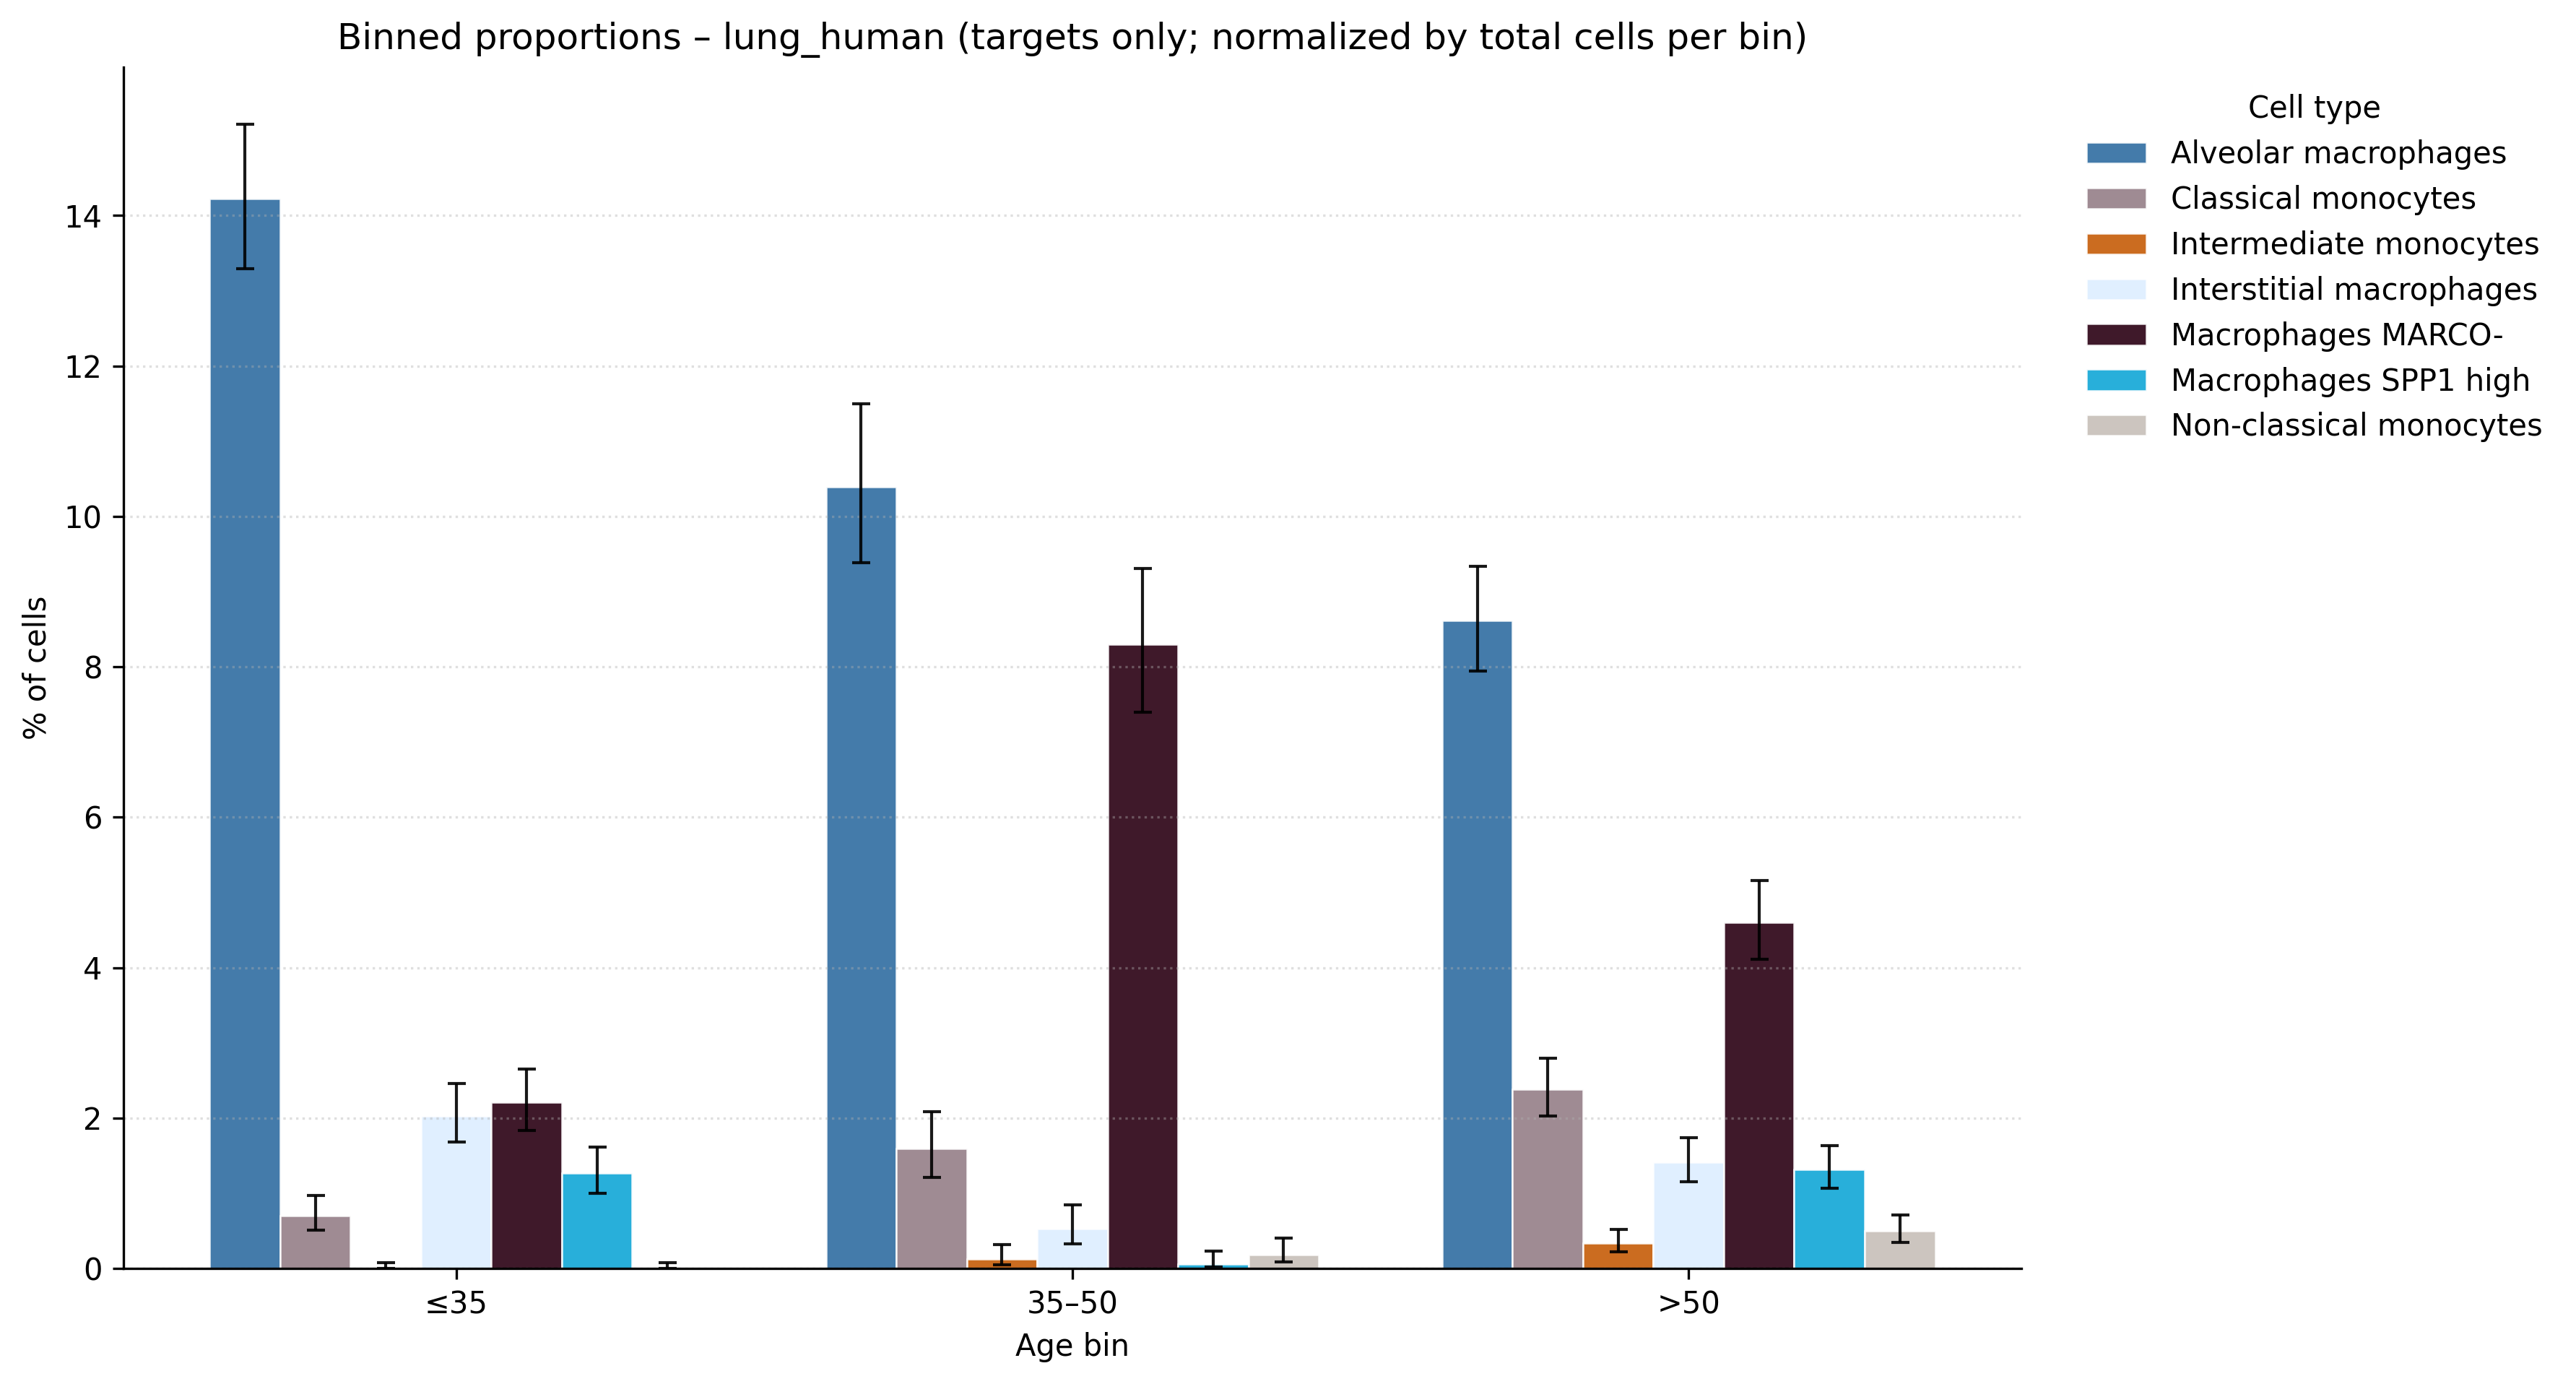

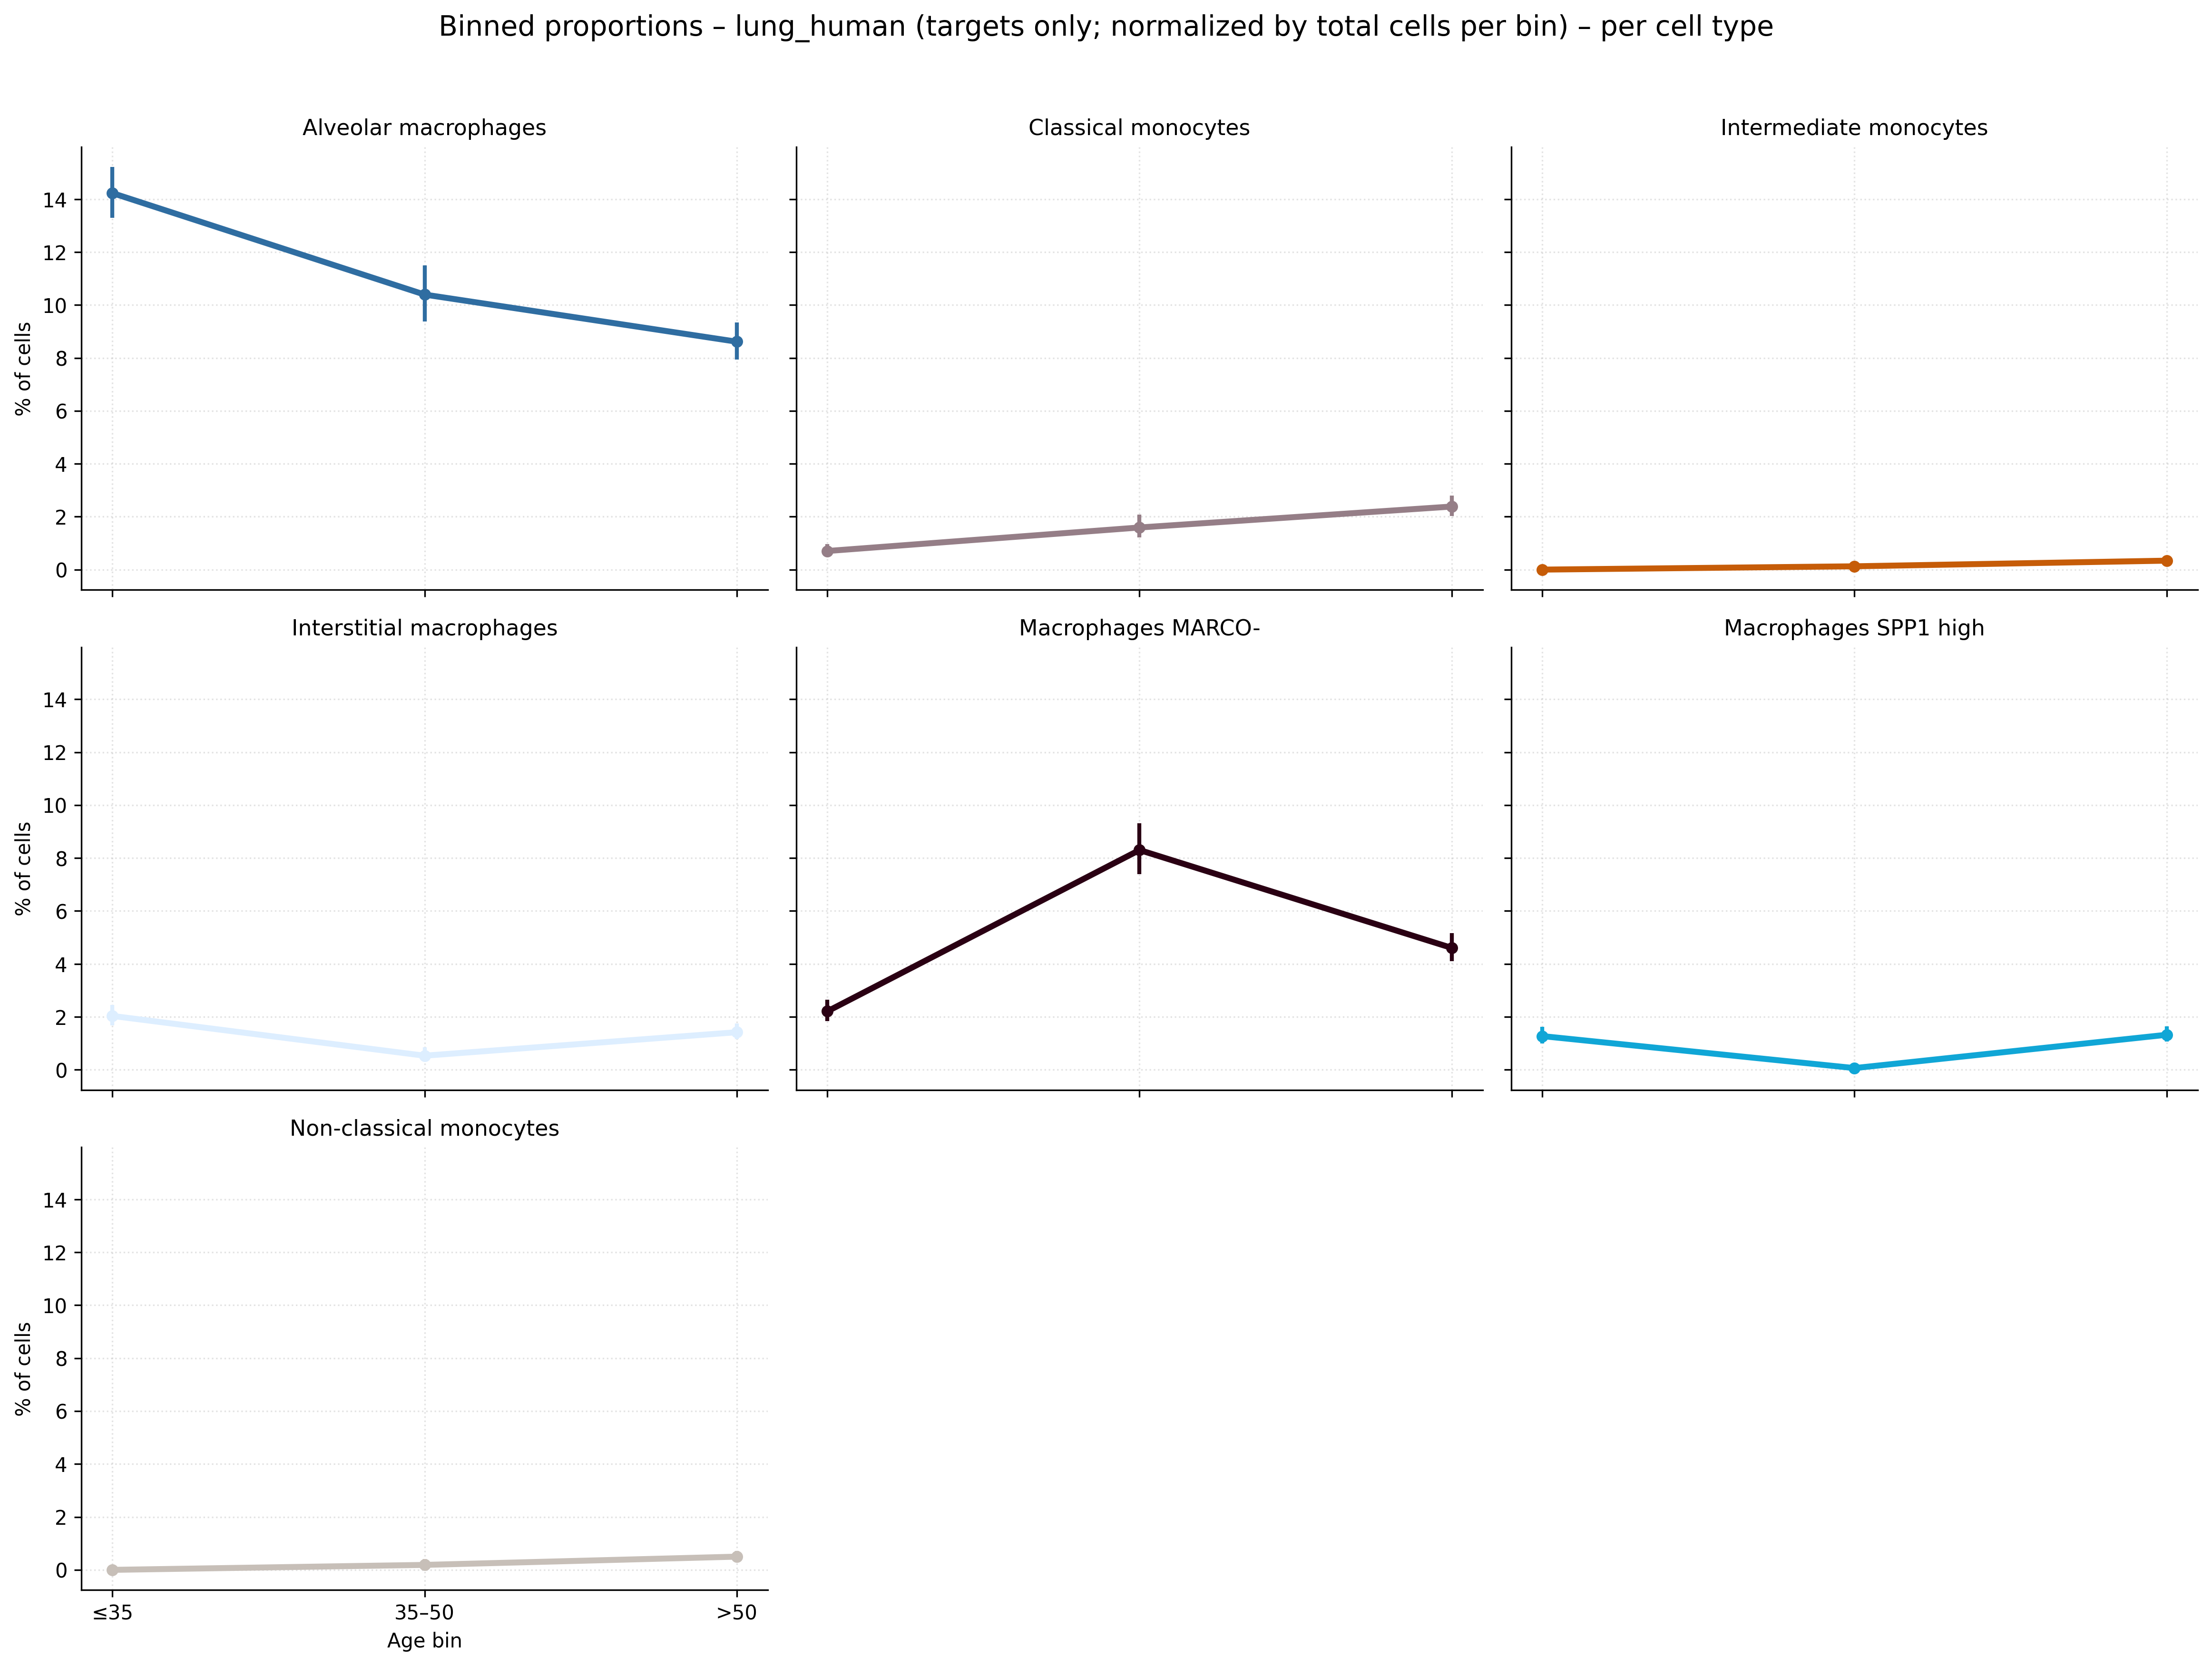

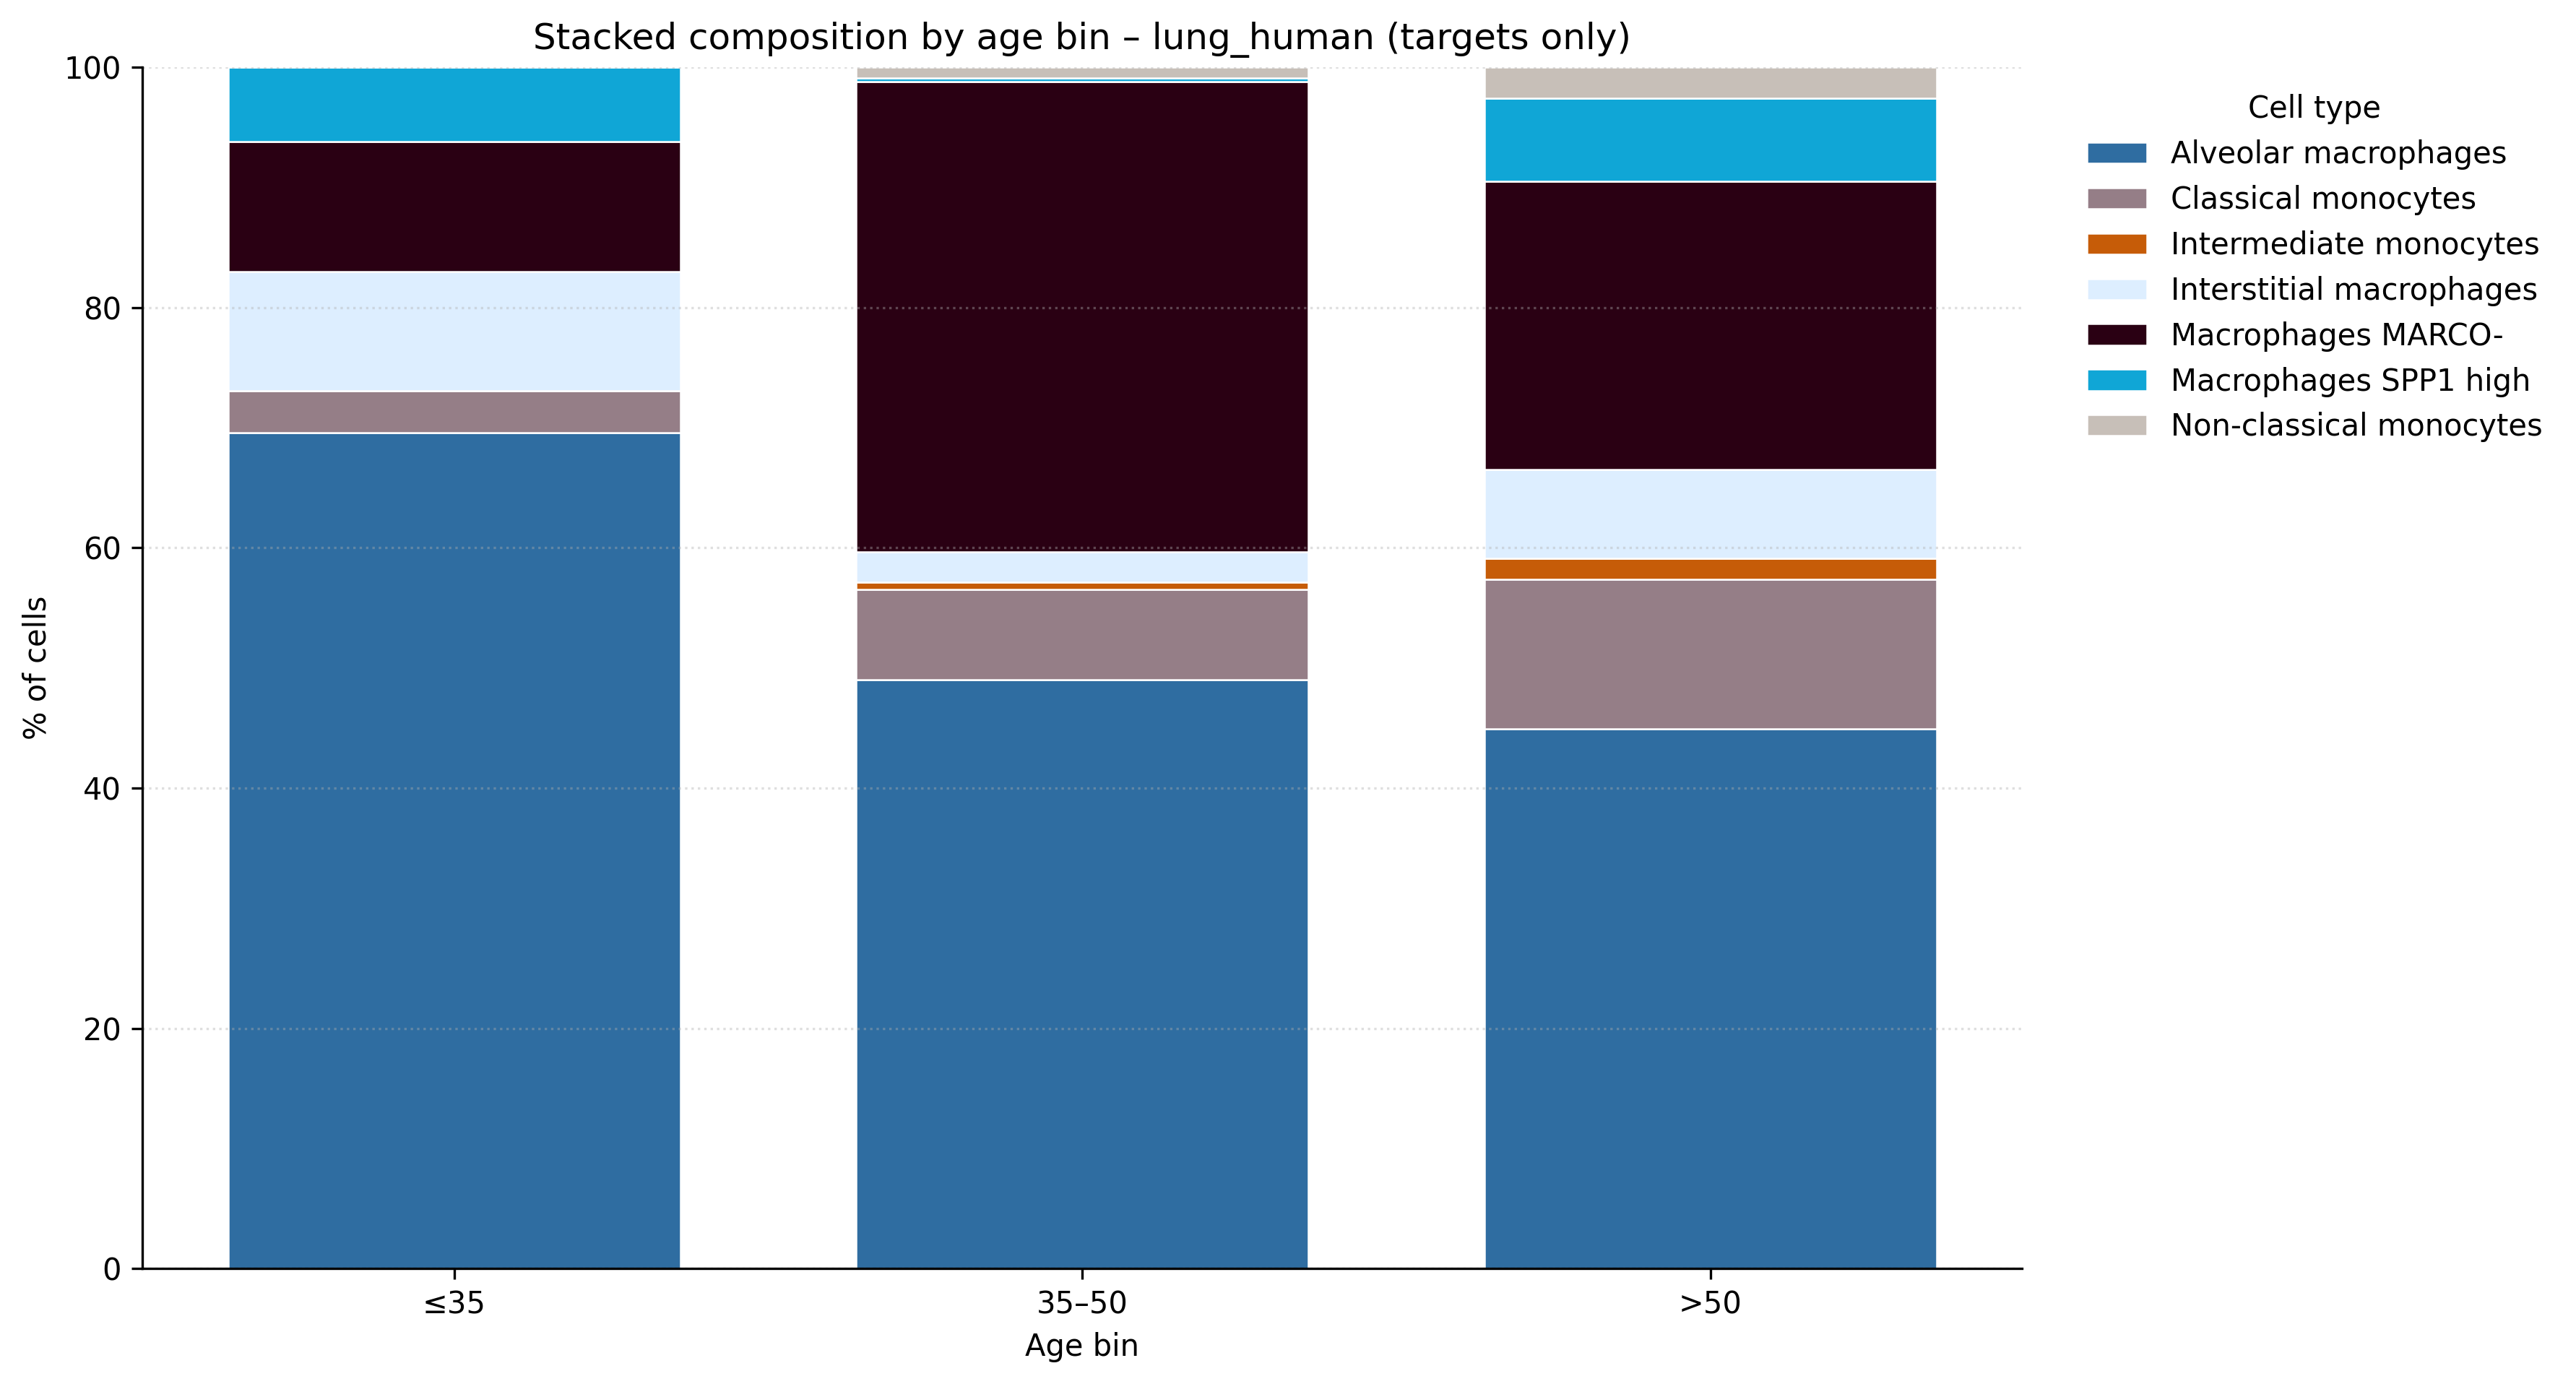

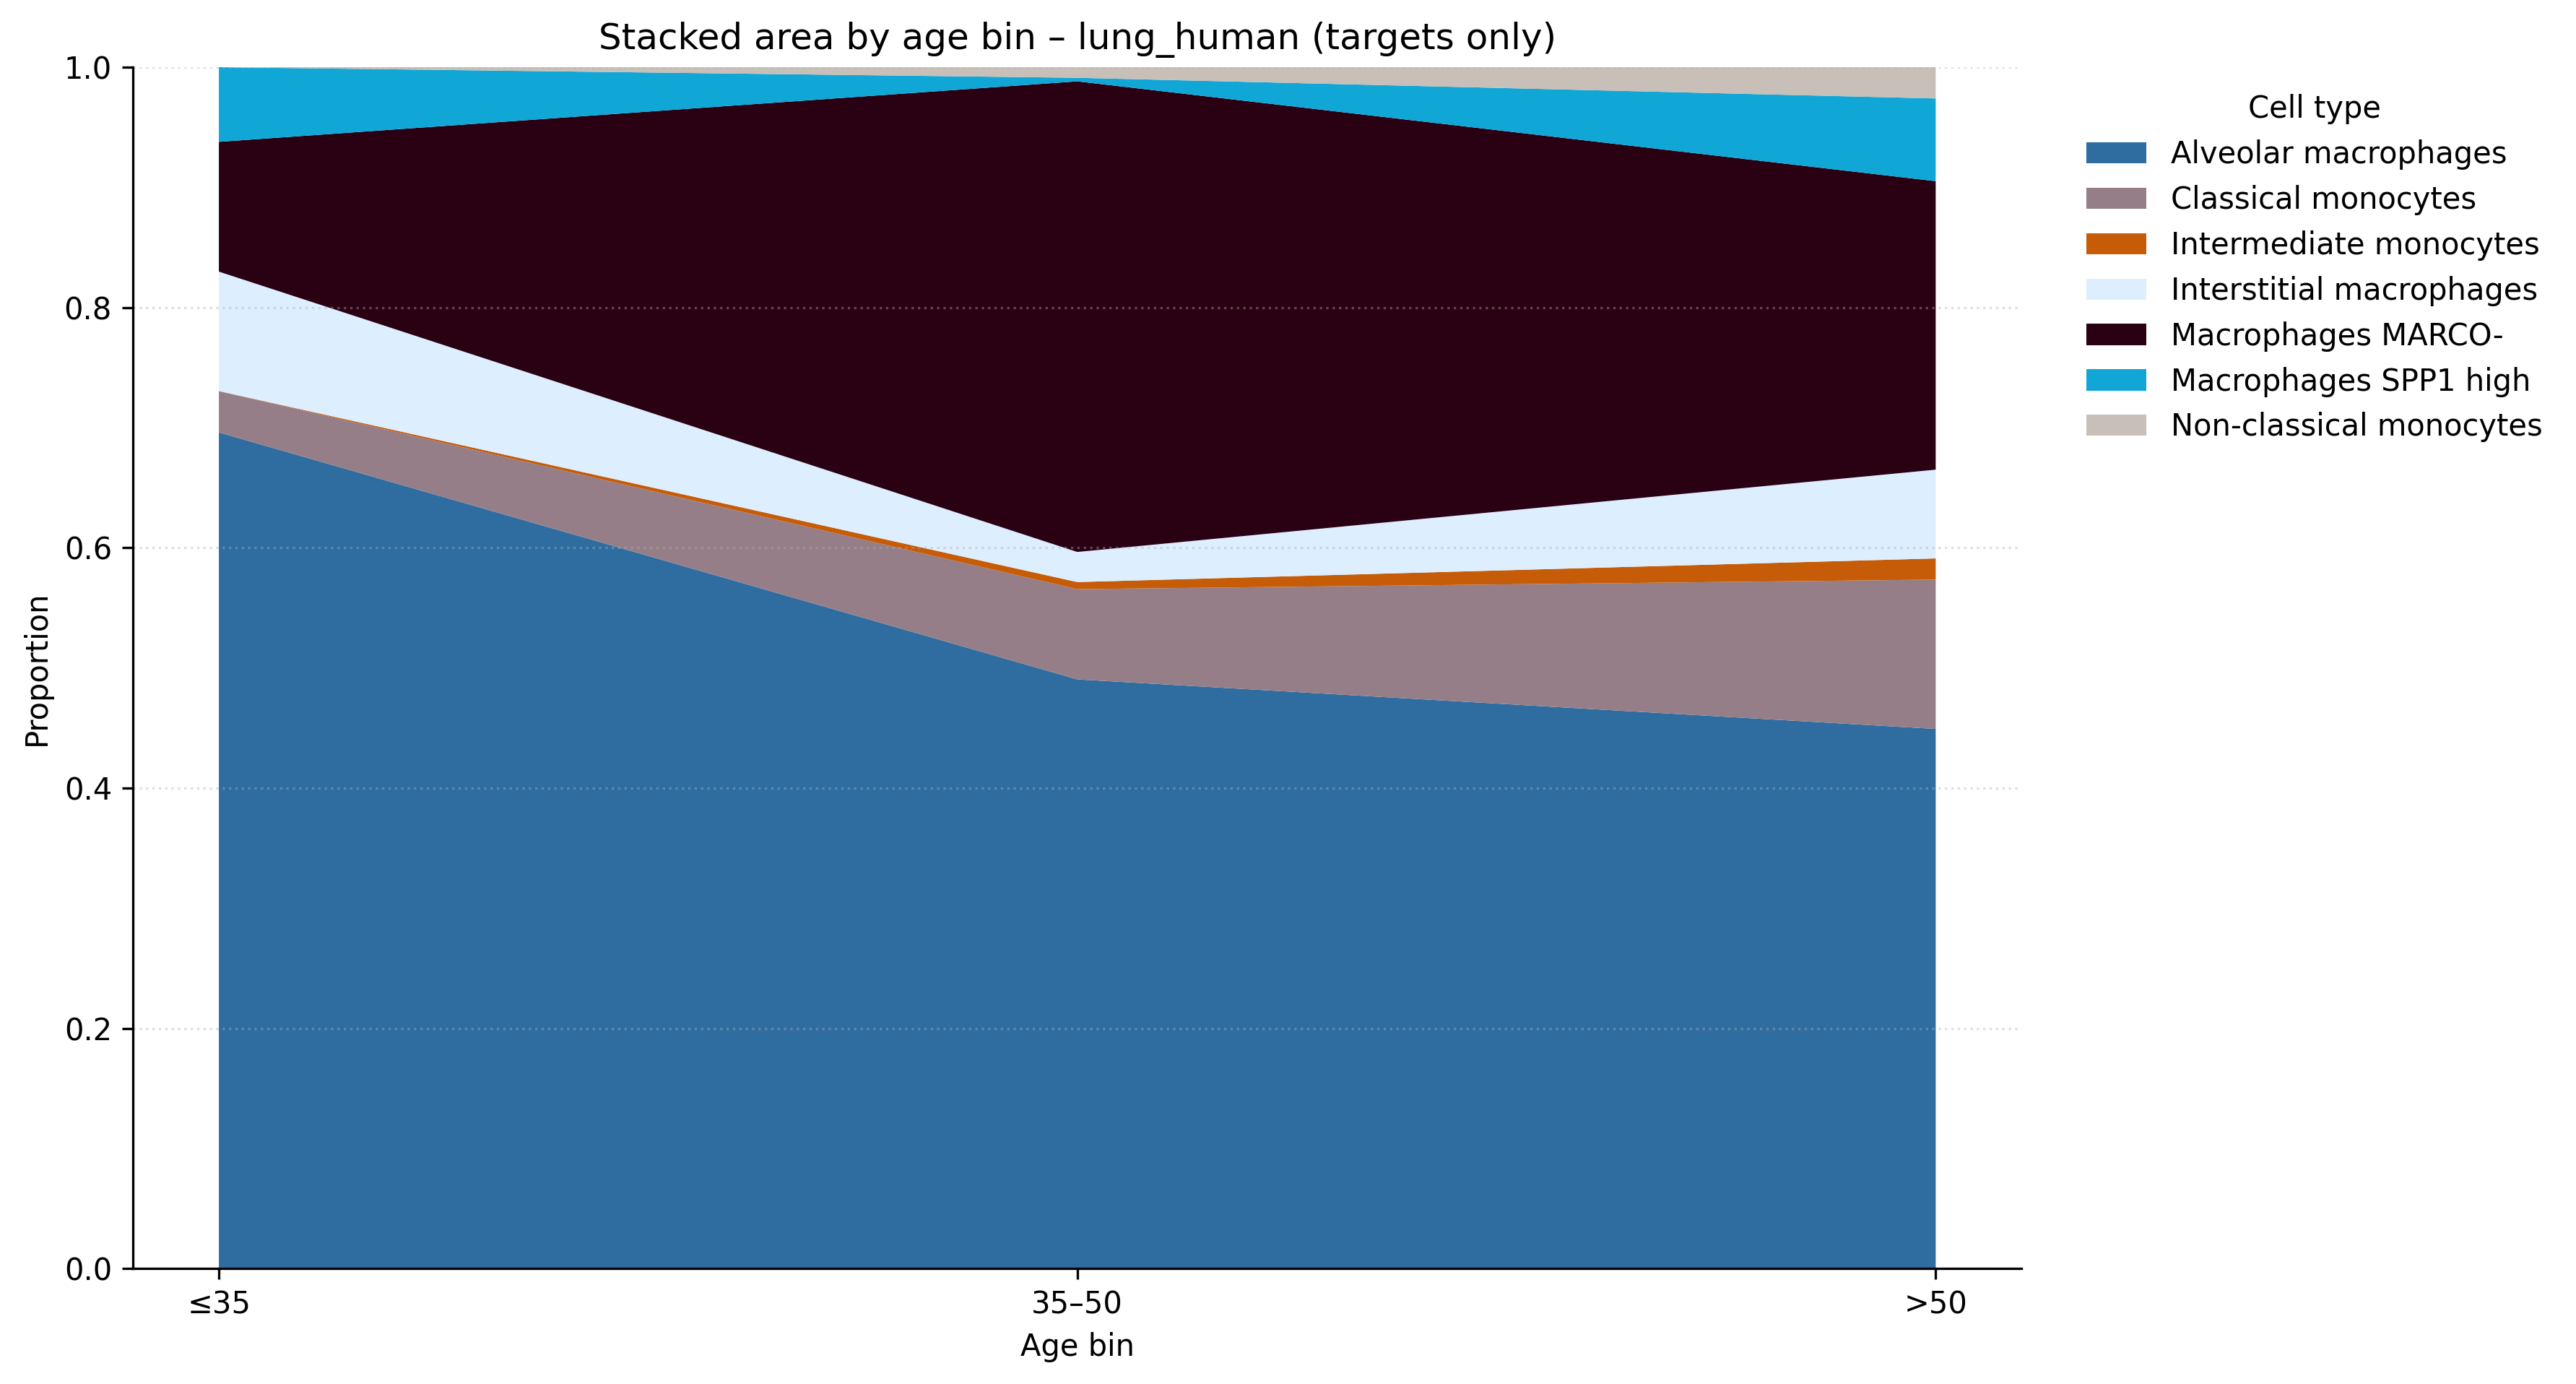

Saved:
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_grouped.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_facets.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_binned_props.csv
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_binned_stats.csv
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_stacked.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked_lung_human_stacked_area.png/.pdf


In [31]:
# ============================================
# Binned cell-type proportions (targets only)
# Palette control (AnnData or manual hex), CIs, stats, plots + stacked variants
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest

# optional inline display (Jupyter)
try:
    from IPython.display import display, Image
    _HAS_IPY = True
except Exception:
    _HAS_IPY = False

# ---- defaults (edit as you like) ----
DEFAULT_CELLTYPE_COL = "original_ann_level_4"
DEFAULT_AGE_FIELD    = "age_or_mean_of_age_range"
FIG_DPI = 300

# ---------- small utils ----------
def _ensure_dir_for_file(path_no_ext: str):
    d = os.path.dirname(path_no_ext)
    if d:
        os.makedirs(d, exist_ok=True)

def _wilson_ci(k: int, n: int, alpha: float = 0.05):
    """Wilson binomial proportion CI."""
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    z = stats.norm.ppf(1 - alpha/2)
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half   = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

def get_palette_hex(adata, palette_col: str, label: str) -> str:
    """
    Return the exact hex color for `label` from adata.uns[f"{palette_col}_colors"]
    aligned to the categorical order of adata.obs[palette_col].
    """
    s = adata.obs[palette_col].astype("category")
    cats = list(s.cat.categories)
    key = f"{palette_col}_colors"
    colors = list(adata.uns[key])
    return colors[cats.index(label)]

def _get_ct_colors(
    adata,
    col: str,
    subset: list[str],
    palette_col: str | None = None,
    overrides: dict | None = None,
) -> dict:
    """
    Build {celltype->color}.
    Priority:
      1) AnnData palette from adata.uns[f"{palette_col}_colors"] if available
      2) fallback Tab20* colors
      3) apply manual overrides last (your hex codes)
    """
    base_col = palette_col or col
    key = f"{base_col}_colors"
    cmap = {}
    use_fallback = False

    if base_col in adata.obs.columns:
        s = adata.obs[base_col].astype("category")
        cats = list(s.cat.categories)
        if key in adata.uns and isinstance(adata.uns[key], (list, tuple)) and len(adata.uns[key]) == len(cats):
            colors = list(adata.uns[key])
            for ct in subset:
                if ct in cats:
                    cmap[ct] = colors[cats.index(ct)]
        elif key in adata.uns and isinstance(adata.uns[key], dict):
            paldict = adata.uns[key]
            for ct in subset:
                if ct in paldict:
                    cmap[ct] = paldict[ct]
                elif ct in cats and str(cats.index(ct)) in paldict:
                    cmap[ct] = paldict[str(cats.index(ct))]
            use_fallback = len(cmap) < len(subset)
        else:
            use_fallback = True
    else:
        use_fallback = True

    if use_fallback:
        pal = (list(plt.cm.get_cmap("tab20").colors)
             + list(plt.cm.get_cmap("tab20b").colors)
             + list(plt.cm.get_cmap("tab20c").colors))
        for i, ct in enumerate(subset):
            cmap[ct] = pal[i % len(pal)]

    if overrides:
        cmap.update({k: overrides[k] for k in overrides if k in subset})

    return cmap

# ---------- core computations ----------
def compute_binned_proportions(
    adata,
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str    = DEFAULT_AGE_FIELD,
    targets: list[str] | None = None,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Returns tidy table with columns:
      age_bin, celltype, successes, trials, prop, ci_low, ci_high
    - successes = # target cells in bin
    - trials    = total # cells in bin (all types)
    - prop      = successes / trials
    - CI        = Wilson 95% CI
    """
    if not targets:
        raise ValueError("Please pass a non-empty list of target cell types.")

    obs = adata.obs[[celltype_col, age_field]].copy()
    obs[age_field] = pd.to_numeric(obs[age_field], errors="coerce")
    obs = obs.dropna(subset=[age_field])

    obs["age_bin"] = pd.cut(
        obs[age_field].astype(float),
        bins=list(bin_edges),
        labels=list(bin_labels),
        right=True,
        include_lowest=True,
    )

    present_targets = [t for t in targets if t in obs[celltype_col].unique()]
    if not present_targets:
        raise ValueError("None of the target cell types are present after filtering ages.")

    # successes among targets
    df_t = obs[obs[celltype_col].isin(present_targets)].copy()
    k = (df_t.groupby(["age_bin", celltype_col]).size()
           .rename("successes").reset_index())

    # trials among ALL cells
    n = (obs.groupby("age_bin").size()
           .rename("trials").reset_index())

    out = k.merge(n, on="age_bin", how="left")
    out["prop"] = out["successes"] / out["trials"].replace(0, np.nan)

    ci = out.apply(lambda r: _wilson_ci(int(r["successes"]), int(r["trials"]), alpha=alpha), axis=1)
    out["ci_low"]  = [c[0] for c in ci]
    out["ci_high"] = [c[1] for c in ci]

    out = out.rename(columns={celltype_col: "celltype"})
    out["age_bin"] = pd.Categorical(out["age_bin"], categories=list(bin_labels), ordered=True)
    out = out[out["celltype"].isin(present_targets)]
    out = out.sort_values(["age_bin", "celltype"]).reset_index(drop=True)
    return out

def test_pairwise_bin_differences(props_df: pd.DataFrame, fdr_method="fdr_bh") -> pd.DataFrame:
    """
    Pairwise two-proportion z-tests between bins per cell type.
    Returns: celltype, bin1, bin2, k1,n1,p1, k2,n2,p2, diff, log2fc, z, pval, pval_adj
    """
    bins = list(props_df["age_bin"].cat.categories)
    pairs = [(bins[0], bins[1]), (bins[0], bins[2]), (bins[1], bins[2])]
    rows = []
    for ct, g in props_df.groupby("celltype"):
        for b1, b2 in pairs:
            r1 = g[g["age_bin"] == b1]; r2 = g[g["age_bin"] == b2]
            if r1.empty or r2.empty:
                continue
            k1, n1 = int(r1["successes"].iloc[0]), int(r1["trials"].iloc[0])
            k2, n2 = int(r2["successes"].iloc[0]), int(r2["trials"].iloc[0])
            if n1 == 0 or n2 == 0:
                stat, pval = (np.nan, np.nan)
            else:
                stat, pval = proportions_ztest([k1, k2], [n1, n2])
            p1 = k1 / (n1 if n1 > 0 else np.nan)
            p2 = k2 / (n2 if n2 > 0 else np.nan)
            rows.append({
                "celltype": ct, "bin1": str(b1), "bin2": str(b2),
                "k1": k1, "n1": n1, "p1": p1,
                "k2": k2, "n2": n2, "p2": p2,
                "diff": p2 - p1,
                "log2fc": np.log2((p2 + 1e-12)/(p1 + 1e-12)),
                "z": stat, "pval": pval
            })
    stats_df = pd.DataFrame(rows)
    if not stats_df.empty:
        stats_df["pval_adj"] = multipletests(stats_df["pval"].values, method=fdr_method)[1]
    return stats_df

# ---------- plotting (grouped bars + faceted lines) ----------
def plot_grouped_bars(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    targets: list[str],
    title_prefix: str = "Binned proportions",
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
):
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = [ct for ct in targets if ct in props_df["celltype"].unique()]
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=celltypes,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    w = min(0.8 / max(len(celltypes), 1), 0.12)
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    for i, ct in enumerate(celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y, lo, hi = sub["prop"].values, sub["ci_low"].values, sub["ci_high"].values
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)  # enforce lo<=y<=hi
        yplot = np.nan_to_num(y * factor, nan=0.0)
        err = np.vstack([
            np.nan_to_num(np.clip(y - lo, 0, None) * factor, nan=0.0),
            np.nan_to_num(np.clip(hi - y, 0, None) * factor, nan=0.0)
        ])
        xpos = x + (i - len(celltypes)/2) * w + w/2
        ax.bar(xpos, yplot, width=w, color=cmap.get(ct), label=ct,
               alpha=0.9, edgecolor="white", linewidth=0.6)
        ax.errorbar(xpos, yplot, yerr=err, fmt="none", ecolor="black",
                    elinewidth=1.0, capsize=3, alpha=0.9)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion")
    ax.set_xlabel("Age bin")
    ax.set_title(title_prefix)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    png = out_base + "_grouped.png"; pdf = out_base + "_grouped.pdf"
    fig.savefig(pdf, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=png))

def plot_faceted_lines(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    targets: list[str],
    title_prefix: str = "Binned proportions – per cell type",
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
):
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = [ct for ct in targets if ct in props_df["celltype"].unique()]
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=celltypes,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0
    n = len(celltypes); cols = min(3, n); rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 3.8*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax, ct in zip(axes, celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y  = sub["prop"].values * factor
        lo = sub["ci_low"].values * factor
        hi = sub["ci_high"].values * factor
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)
        err_low  = np.nan_to_num(np.clip(y - lo, 0, None), nan=0.0)
        err_high = np.nan_to_num(np.clip(hi - y, 0, None), nan=0.0)

        color = cmap.get(ct)
        ax.plot(x, np.nan_to_num(y, nan=0.0), "-o", linewidth=3.0, markersize=5, color=color)
        for xi, yy, el, eh in zip(x, y, err_low, err_high):
            ax.vlines([xi], yy - el, yy + eh, color=color, linewidth=2.0)

        ax.set_title(ct, fontsize=11)
        ax.grid(True, linestyle=":", alpha=0.35)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    for ax in axes[len(celltypes):]:
        ax.axis("off")
    for ax in axes[-cols:]:
        ax.set_xticks(x); ax.set_xticklabels(bins); ax.set_xlabel("Age bin")
    for r in range(0, len(axes), cols):
        axes[r].set_ylabel("% of cells" if as_percent else "Proportion")

    fig.suptitle(title_prefix, y=1.02, fontsize=14)
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    png = out_base + "_facets.png"; pdf = out_base + "_facets.pdf"
    fig.savefig(pdf, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=png))

# ---------- stacked variants ----------
def _pivot_props_for_stacking(props_df, targets):
    """Pivot to bins × targets, normalize rows to 1.0."""
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    cols = [ct for ct in targets if ct in props_df["celltype"].unique()]
    pivot = (
        props_df.pivot_table(index="age_bin", columns="celltype", values="prop", fill_value=0.0)
                .reindex(index=bins)
                .reindex(columns=cols)
                .fillna(0.0)
    )
    row_sums = pivot.sum(axis=1).replace(0, np.nan)
    pivot = pivot.div(row_sums, axis=0).fillna(0.0)
    return pivot

def plot_stacked_bars(
    props_df,
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    as_percent: bool = True,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    show: bool = False,
    bar_width: float = 0.72,
):
    """100% stacked bars per age bin (only targets)."""
    pivot = _pivot_props_for_stacking(props_df, targets)
    bins = list(pivot.index)
    cols = list(pivot.columns)
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=cols,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    bottom = np.zeros(len(bins), dtype=float)
    for ct in cols:
        y = pivot[ct].values * factor
        ax.bar(x, y, bottom=bottom, width=bar_width,
               color=cmap.get(ct), edgecolor="white", linewidth=0.6, label=ct)
        bottom += y

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion")
    ax.set_xlabel("Age bin")
    ax.set_ylim(0, 100 if as_percent else 1.0)
    ax.set_title(f"Stacked composition by age bin – {tissue} (targets only)")
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")

    fig.tight_layout()
    base = f"{out_base}_{tissue}_stacked"
    _ensure_dir_for_file(base)
    fig.savefig(base + ".pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(base + ".png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=base + ".png"))

def plot_stacked_area(
    props_df,
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    show: bool = False,
):
    """Stacked area (same data as bars)."""
    pivot = _pivot_props_for_stacking(props_df, targets)
    bins = list(pivot.index)
    cols = list(pivot.columns)
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=cols,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    colors = [cmap[c] for c in cols]

    fig, ax = plt.subplots(figsize=(12, 6.5))
    ax.stackplot(x, pivot.values.T, labels=cols, colors=colors, linewidth=0.0)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Age bin")
    ax.set_ylim(0, 1.0)
    ax.set_title(f"Stacked area by age bin – {tissue} (targets only)")
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")

    fig.tight_layout()
    base = f"{out_base}_{tissue}_stacked_area"
    _ensure_dir_for_file(base)
    fig.savefig(base + ".pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(base + ".png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=base + ".png"))

# ---------- high-level wrapper ----------
def make_binned_plots_and_stats(
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str = DEFAULT_AGE_FIELD,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    make_stacked: bool = False,
    make_stacked_area_plot: bool = False,
):
    """
    Orchestrates: compute props, plot (grouped + facets), stats, save CSVs.
    Optional: also make stacked bars/area.
    """
    props = compute_binned_proportions(
        adata,
        celltype_col=celltype_col,
        age_field=age_field,
        targets=targets,
        bin_edges=bin_edges,
        bin_labels=bin_labels,
        alpha=alpha,
    )

    title = f"Binned proportions – {tissue} (targets only; normalized by total cells per bin)"
    base = f"{out_base}_{tissue}"

    plot_grouped_bars(
        props, adata, out_base=base, targets=targets,
        title_prefix=title, as_percent=as_percent, show=show,
        palette_col=palette_col, color_overrides=color_overrides
    )
    plot_faceted_lines(
        props, adata, out_base=base, targets=targets,
        title_prefix=f"{title} – per cell type", as_percent=as_percent, show=show,
        palette_col=palette_col, color_overrides=color_overrides
    )

    if make_stacked:
        plot_stacked_bars(
            props, adata, out_base=out_base, tissue=tissue, targets=targets,
            as_percent=as_percent, palette_col=palette_col,
            color_overrides=color_overrides, show=show
        )
    if make_stacked_area_plot:
        plot_stacked_area(
            props, adata, out_base=out_base, tissue=tissue, targets=targets,
            palette_col=palette_col, color_overrides=color_overrides, show=show
        )

    stats_df = test_pairwise_bin_differences(props)

    _ensure_dir_for_file(out_base)
    props.to_csv(base + "_binned_props.csv", index=False)
    stats_df.to_csv(base + "_binned_stats.csv", index=False)
    print(f"Saved:\n  {base}_grouped.png/.pdf\n  {base}_facets.png/.pdf\n  {base}_binned_props.csv\n  {base}_binned_stats.csv")
    if make_stacked:
        print(f"  {out_base}_{tissue}_stacked.png/.pdf")
    if make_stacked_area_plot:
        print(f"  {out_base}_{tissue}_stacked_area.png/.pdf")
    return props, stats_df

# -------------------------
# Example usage (uncomment and edit paths to run)
# -------------------------
targets = [
    "Alveolar macrophages",
    "Classical monocytes",
    "Intermediate monocytes",
    "Interstitial macrophages",
    "Macrophages MARCO-",
    "Macrophages SPP1 high",
    "Non-classical monocytes",
]

# Manual hex overrides (Option B). Replace values with your exact swatches.
overrides = {
    "Classical monocytes": "#957E87",   # <- your code here
    "Alveolar macrophages": "#2F6DA1",
    "Intermediate monocytes": "#C65C08",
    "Interstitial macrophages":"#DDEEFF",
    "Macrophages MARCO-":"#2A0013",
    "Macrophages SPP1 high":"#10A6D6",
    "Non-classical monocytes":"#C7BFB8",
}

props, stats_df = make_binned_plots_and_stats(
    adata,
    out_base="/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/pls-regression-last-edit-stacked",
    tissue="lung_human",
    targets=targets,
    celltype_col="original_ann_level_4",
    age_field="age_or_mean_of_age_range",
    palette_col="original_ann_level_4",  # use AnnData palette for others
    color_overrides=overrides,           # force your hex for listed types
    show=True,                           # display inline + save
    as_percent=True,
    make_stacked=True,                   # also make 100% stacked bars
    make_stacked_area_plot=True,         # and stacked area
)


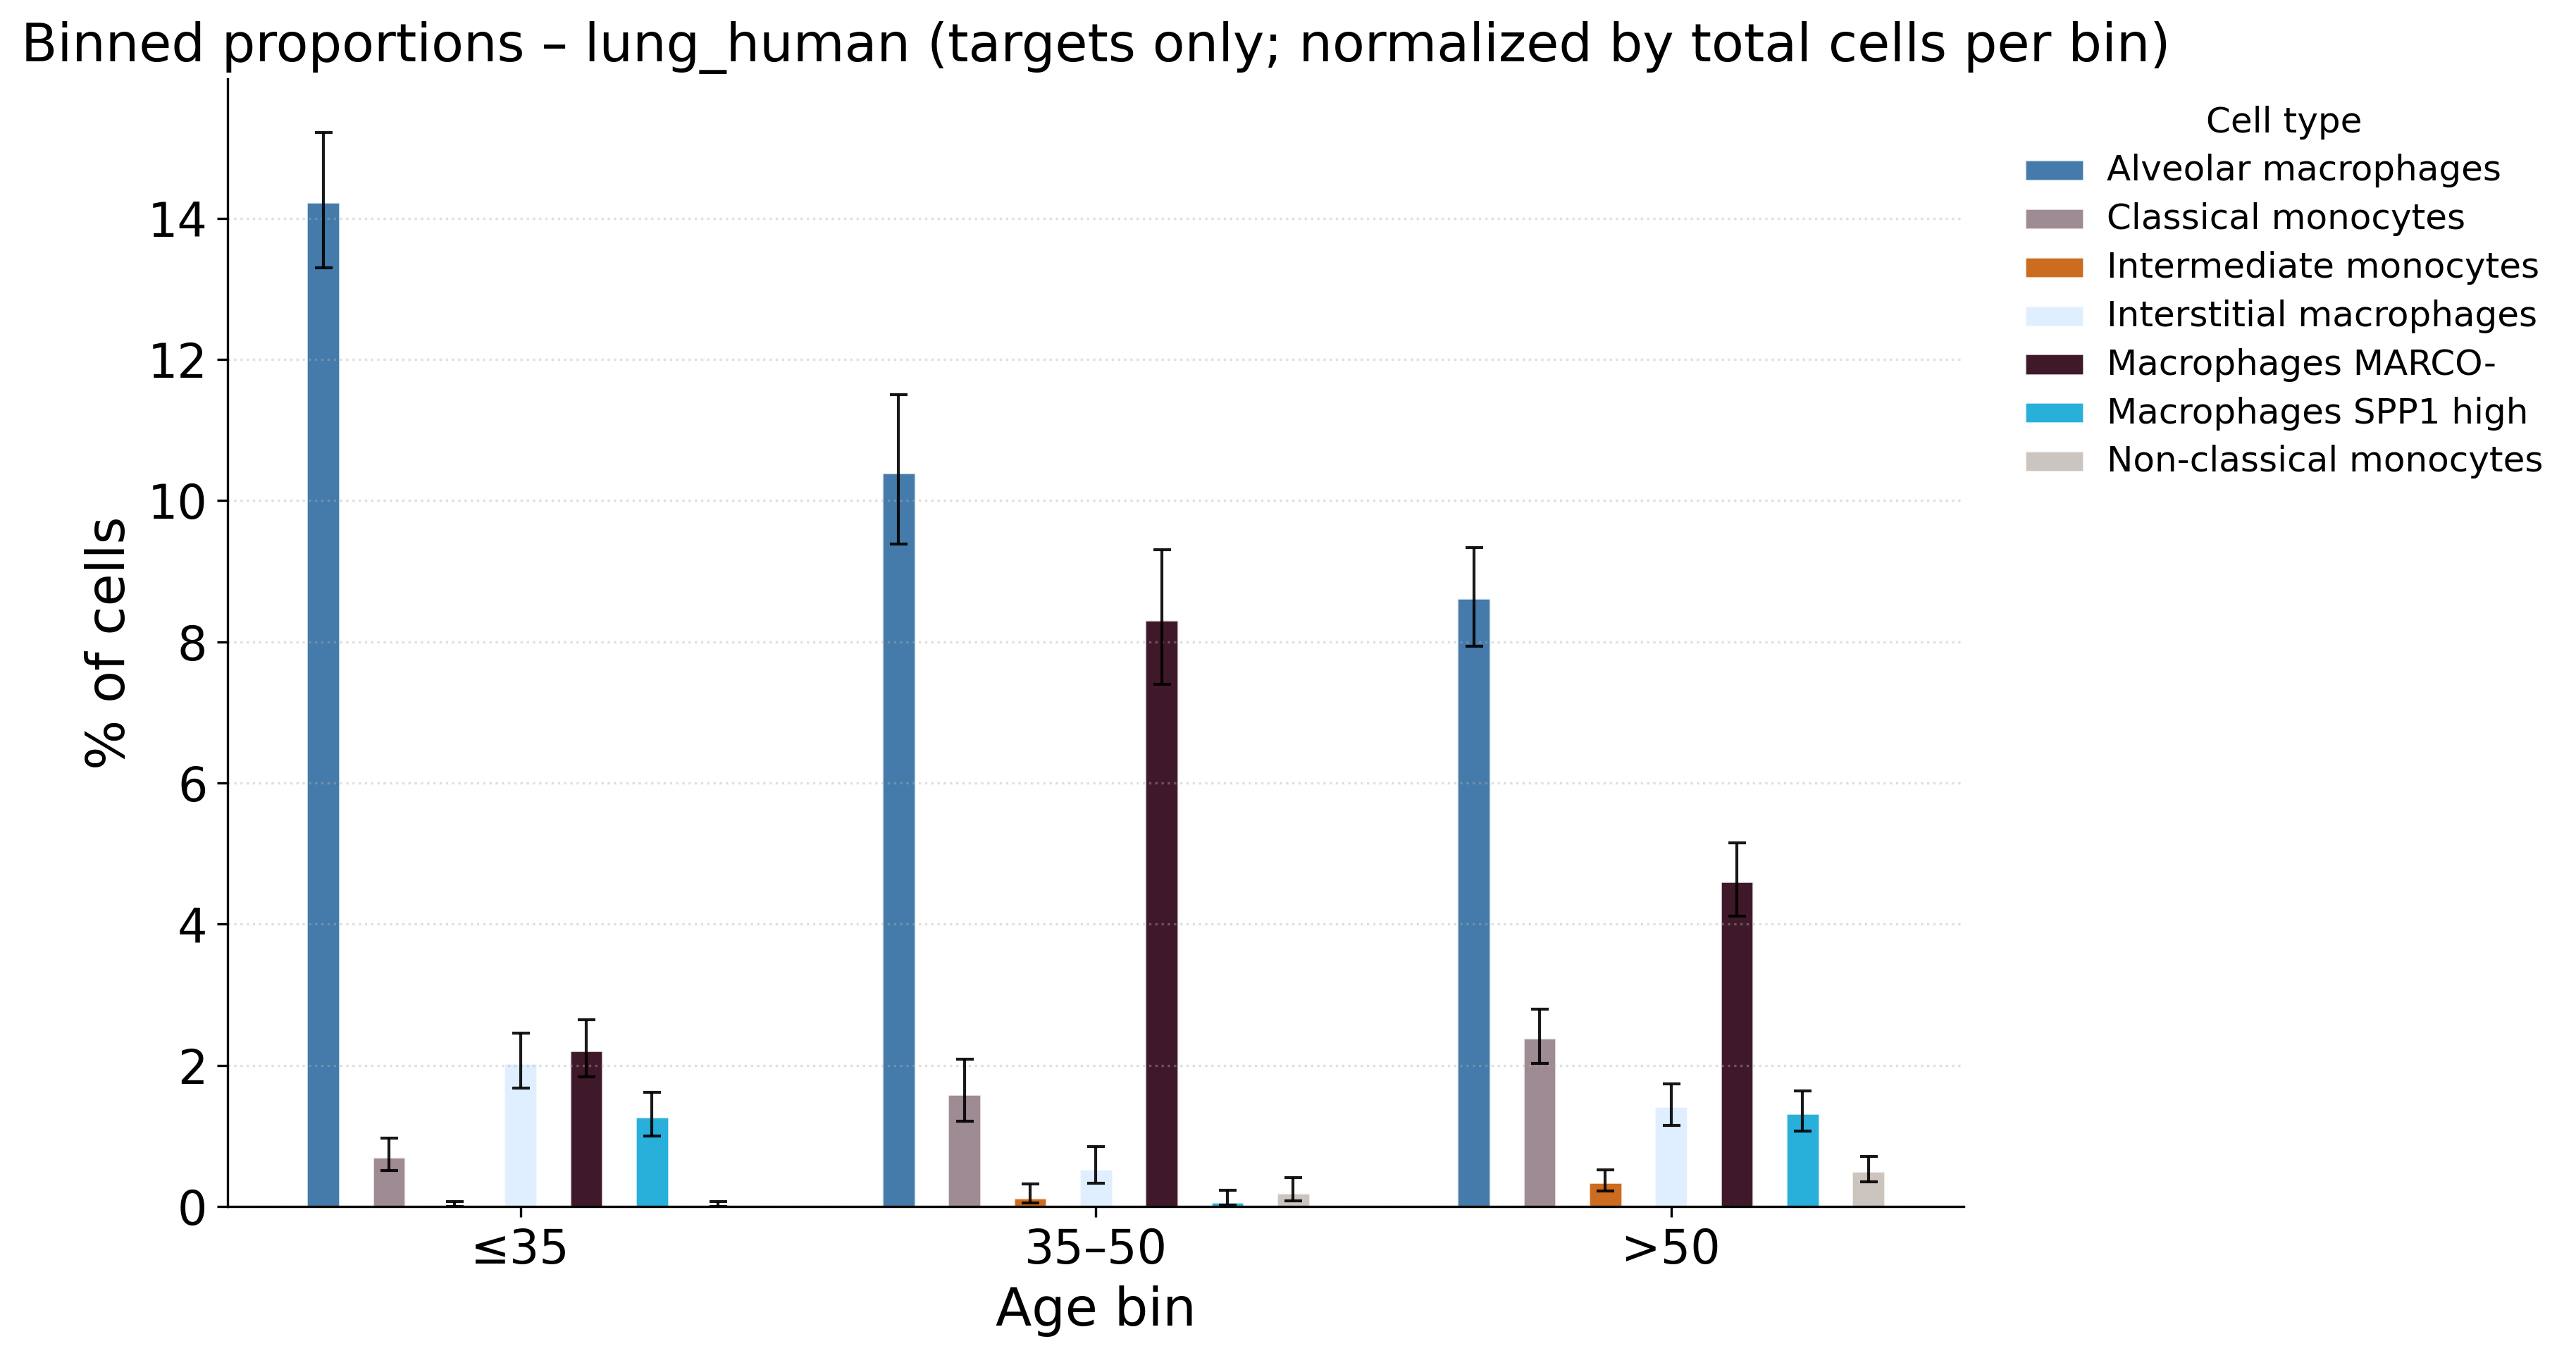

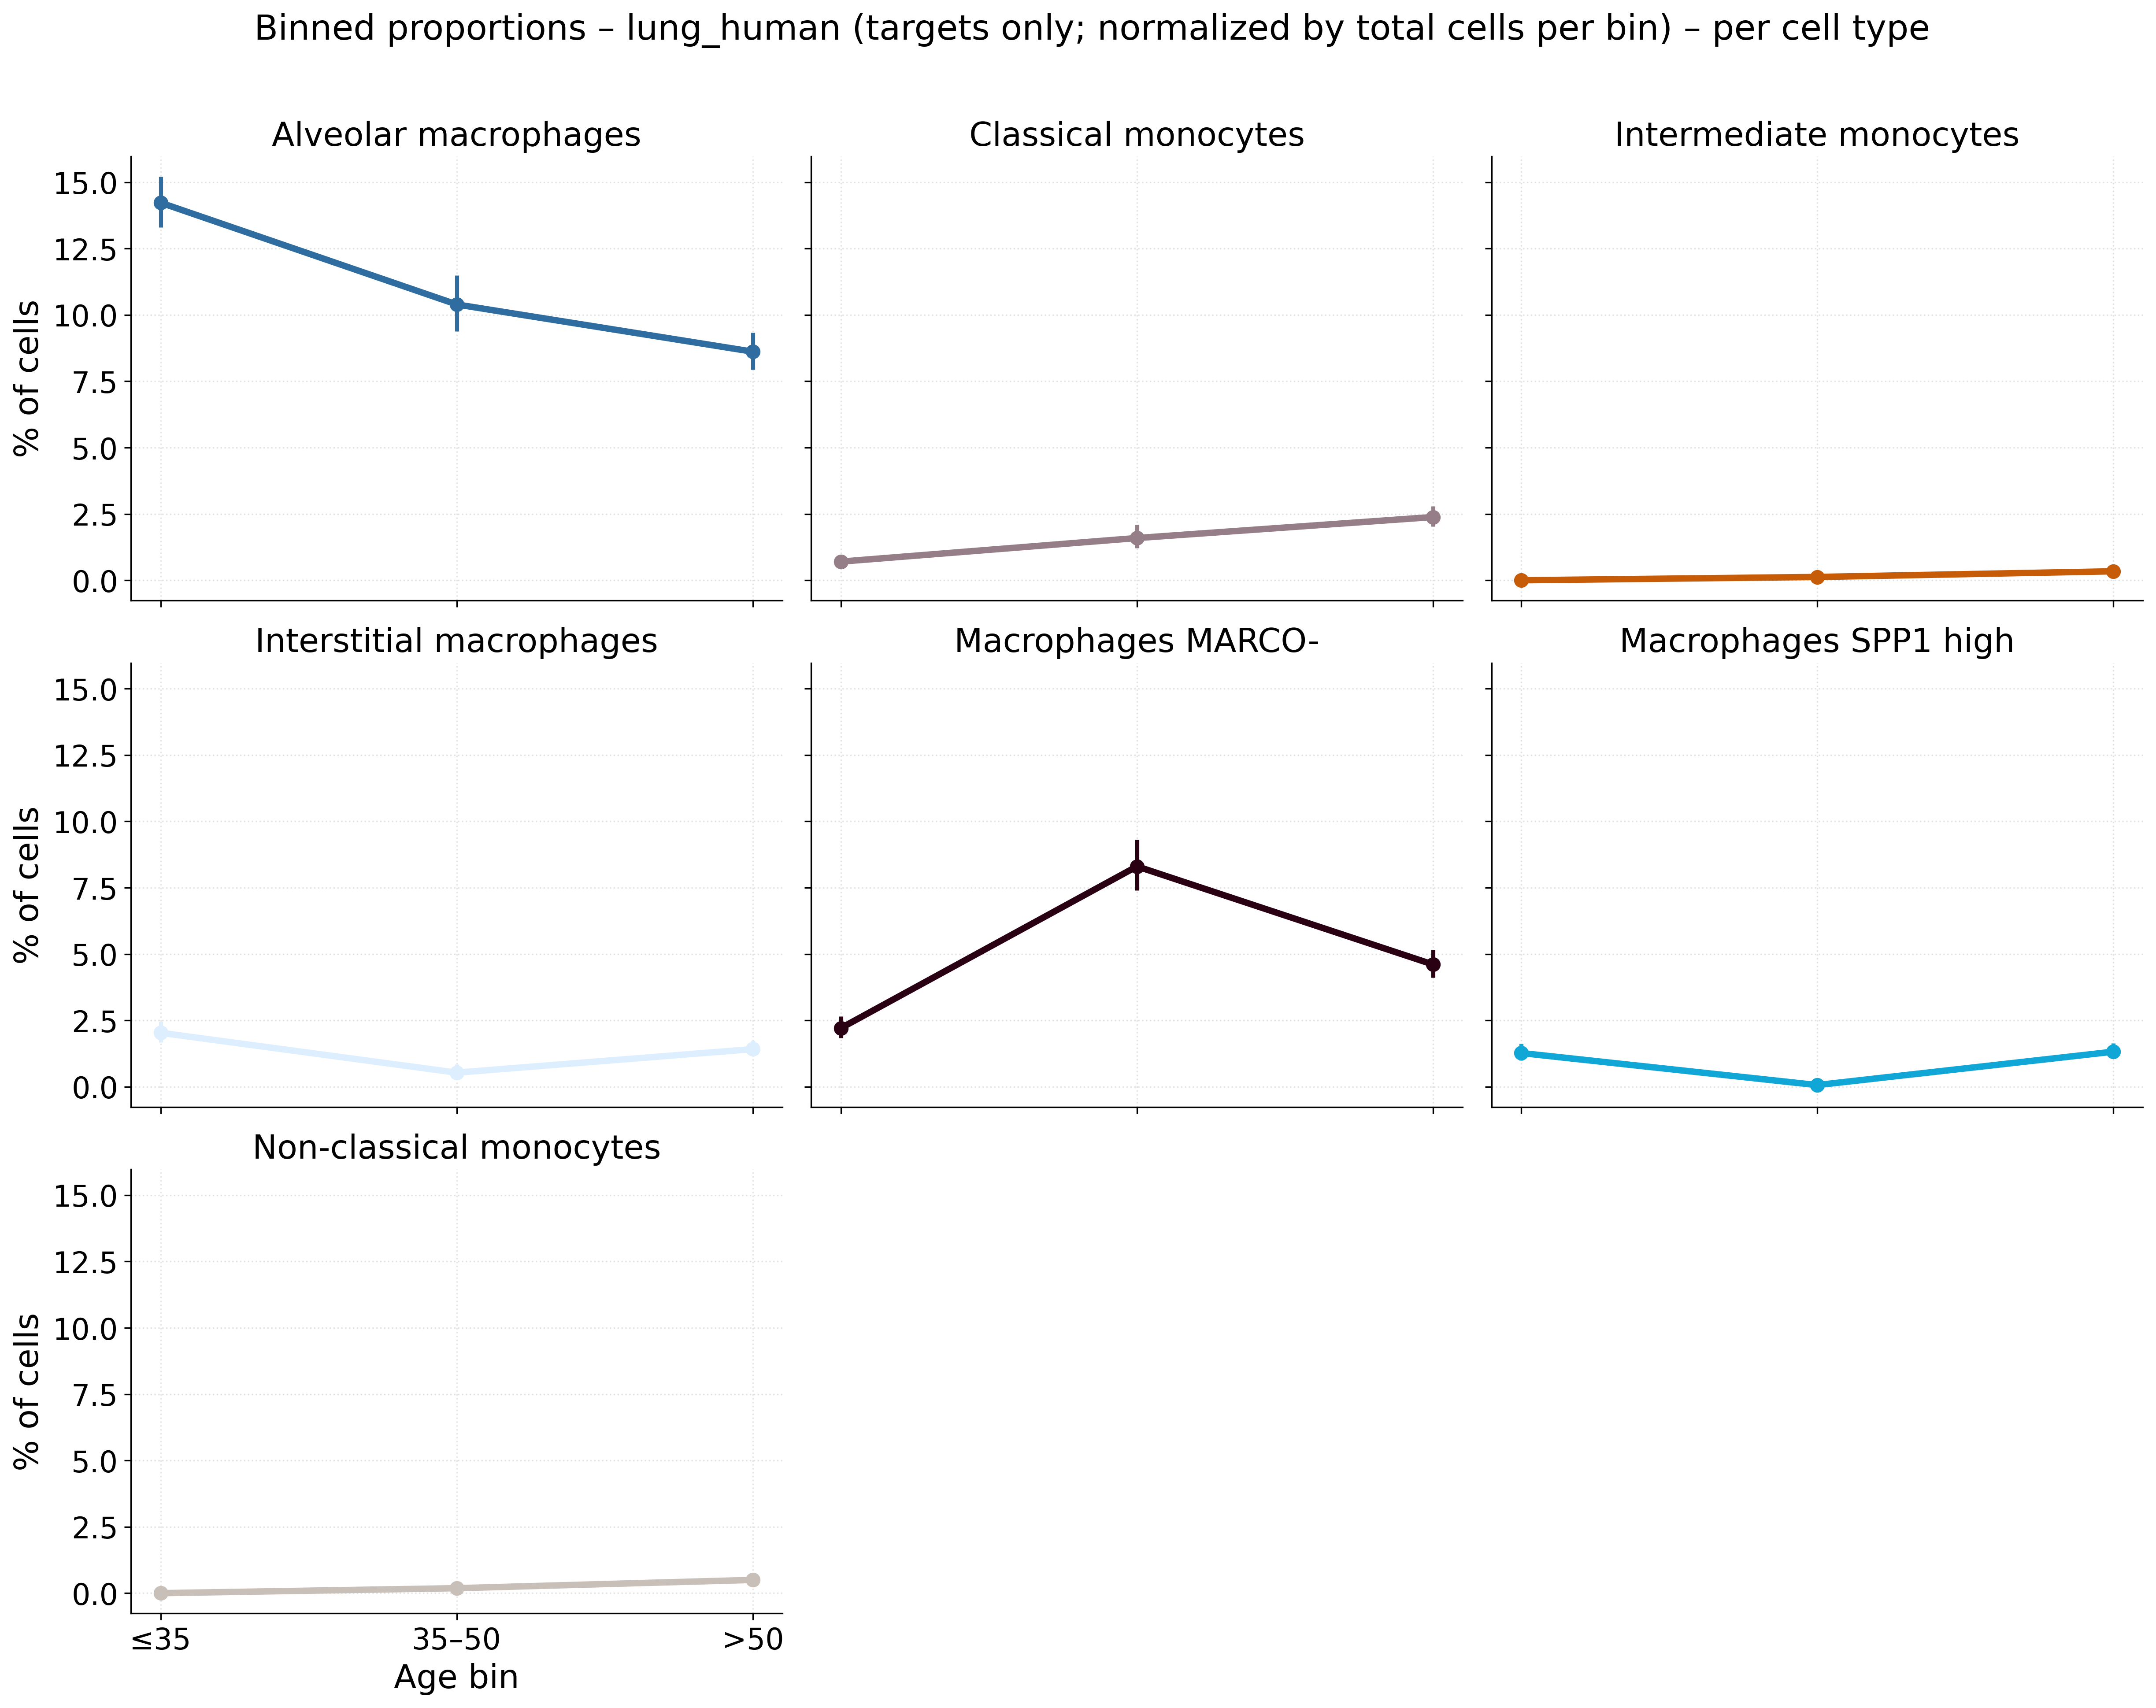

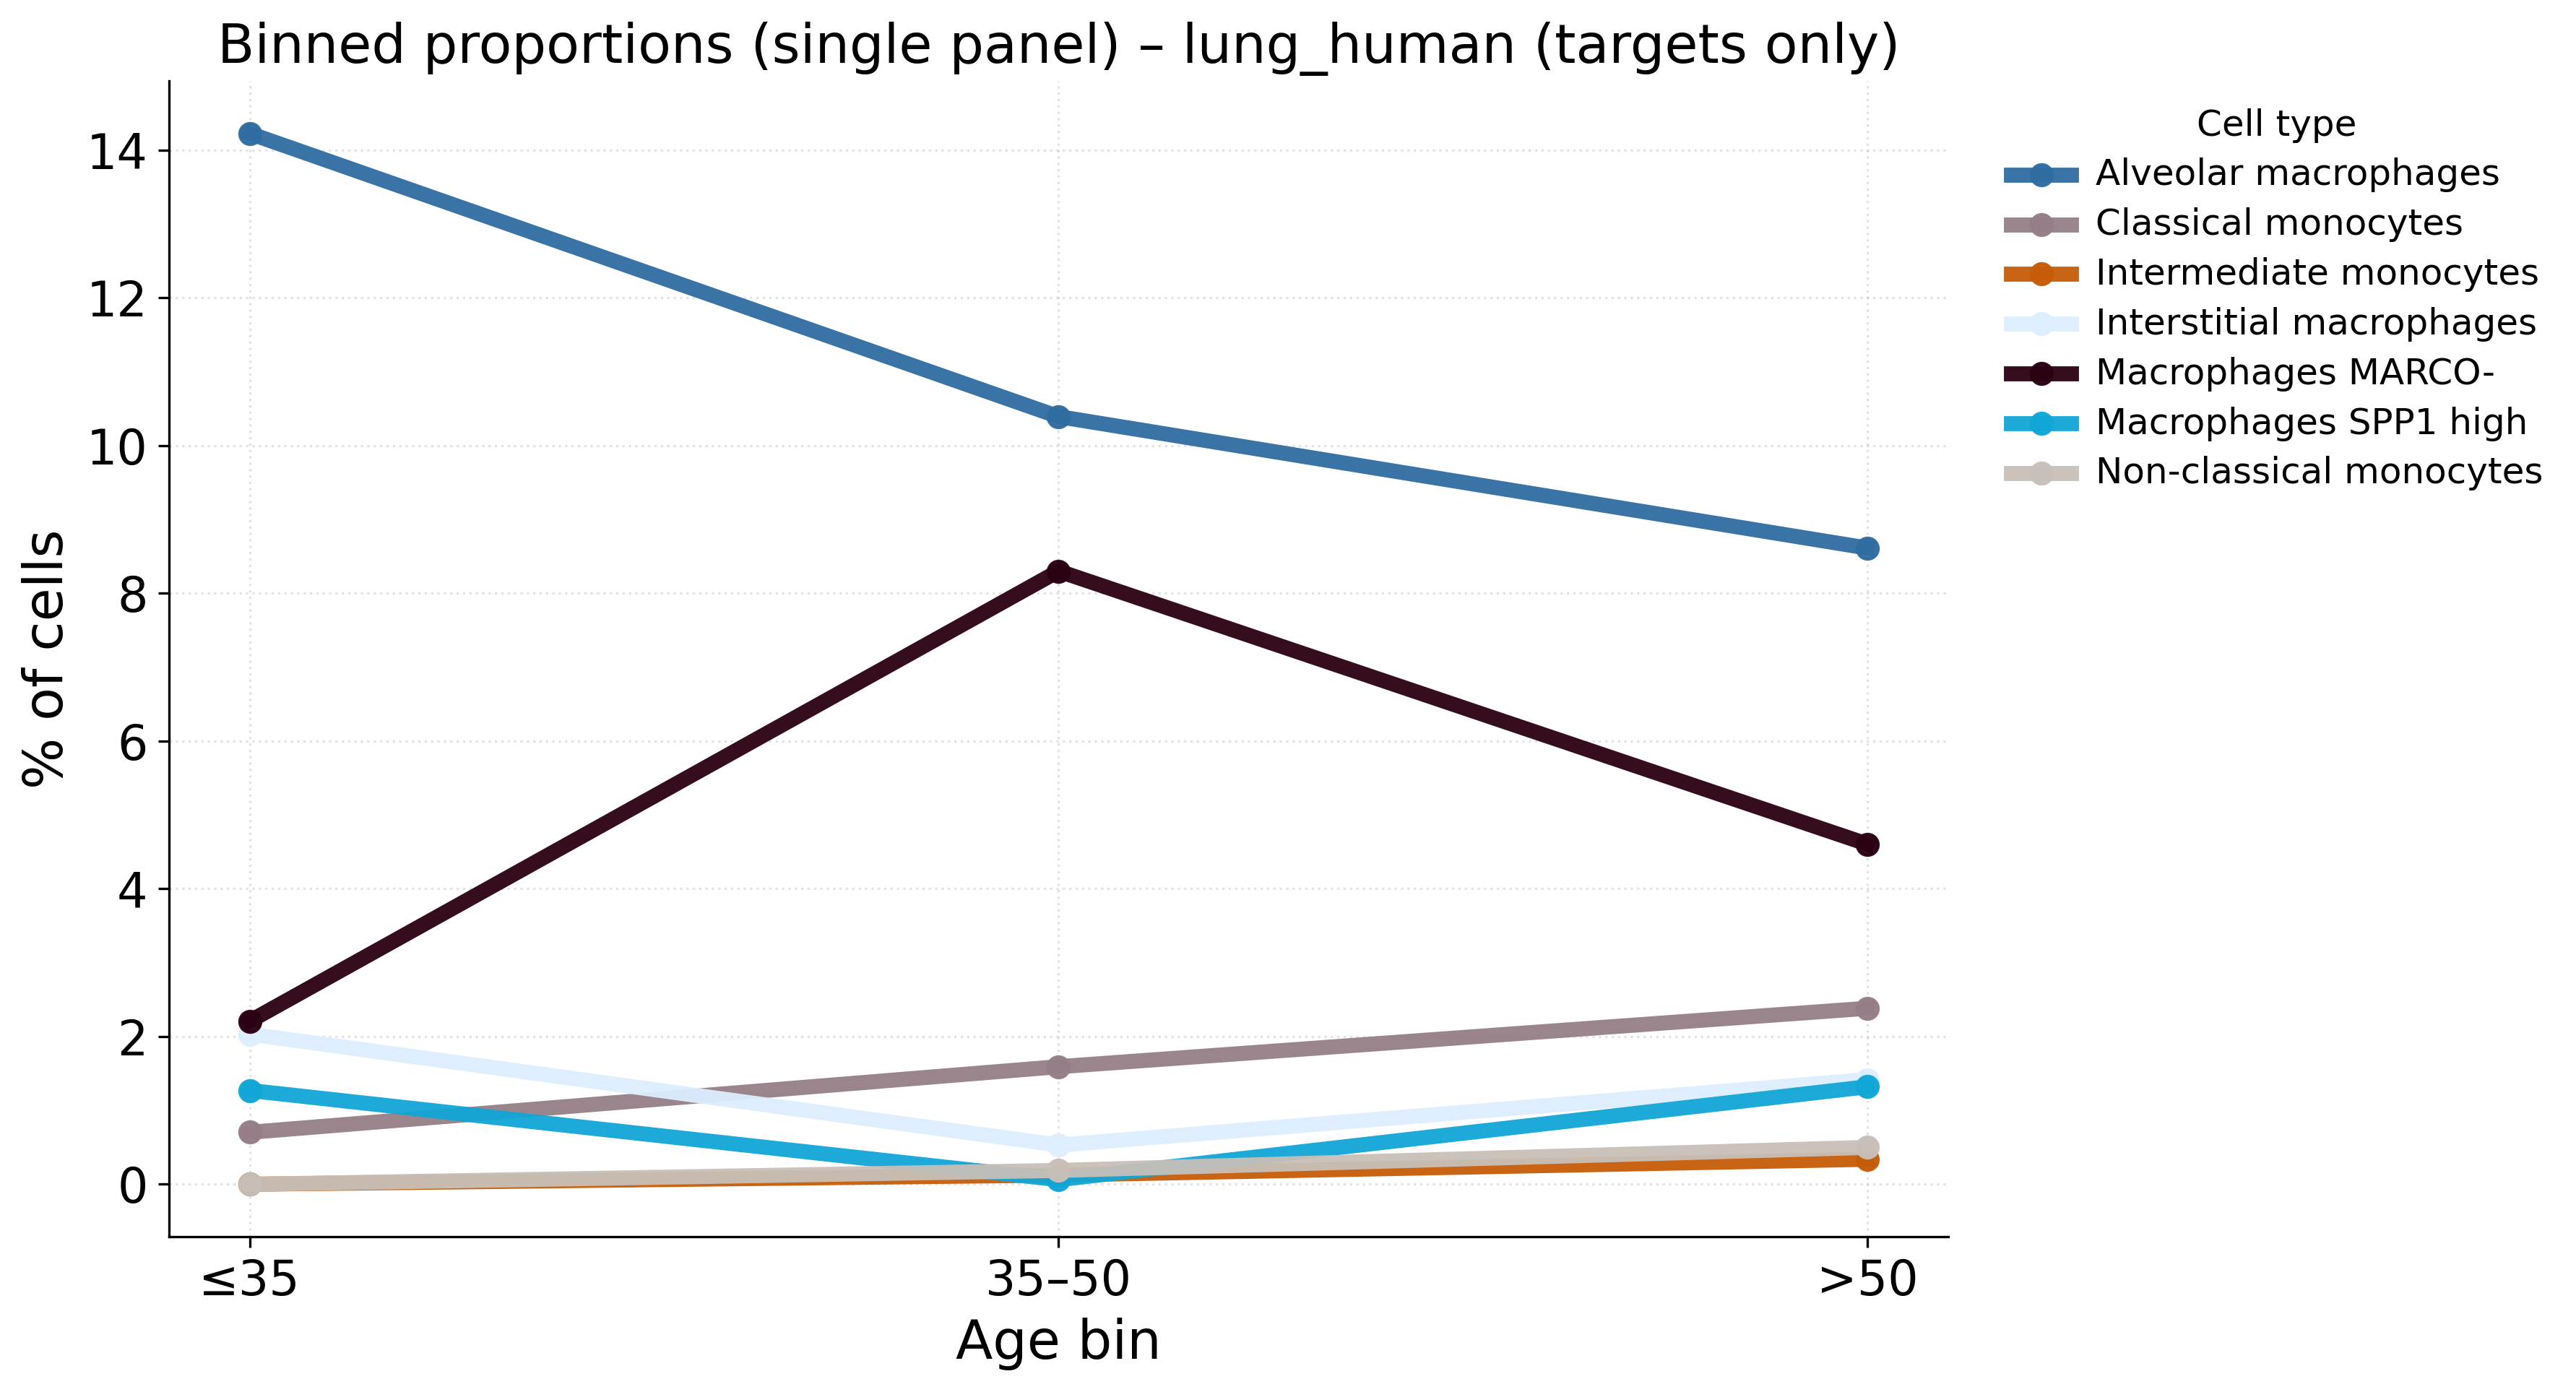

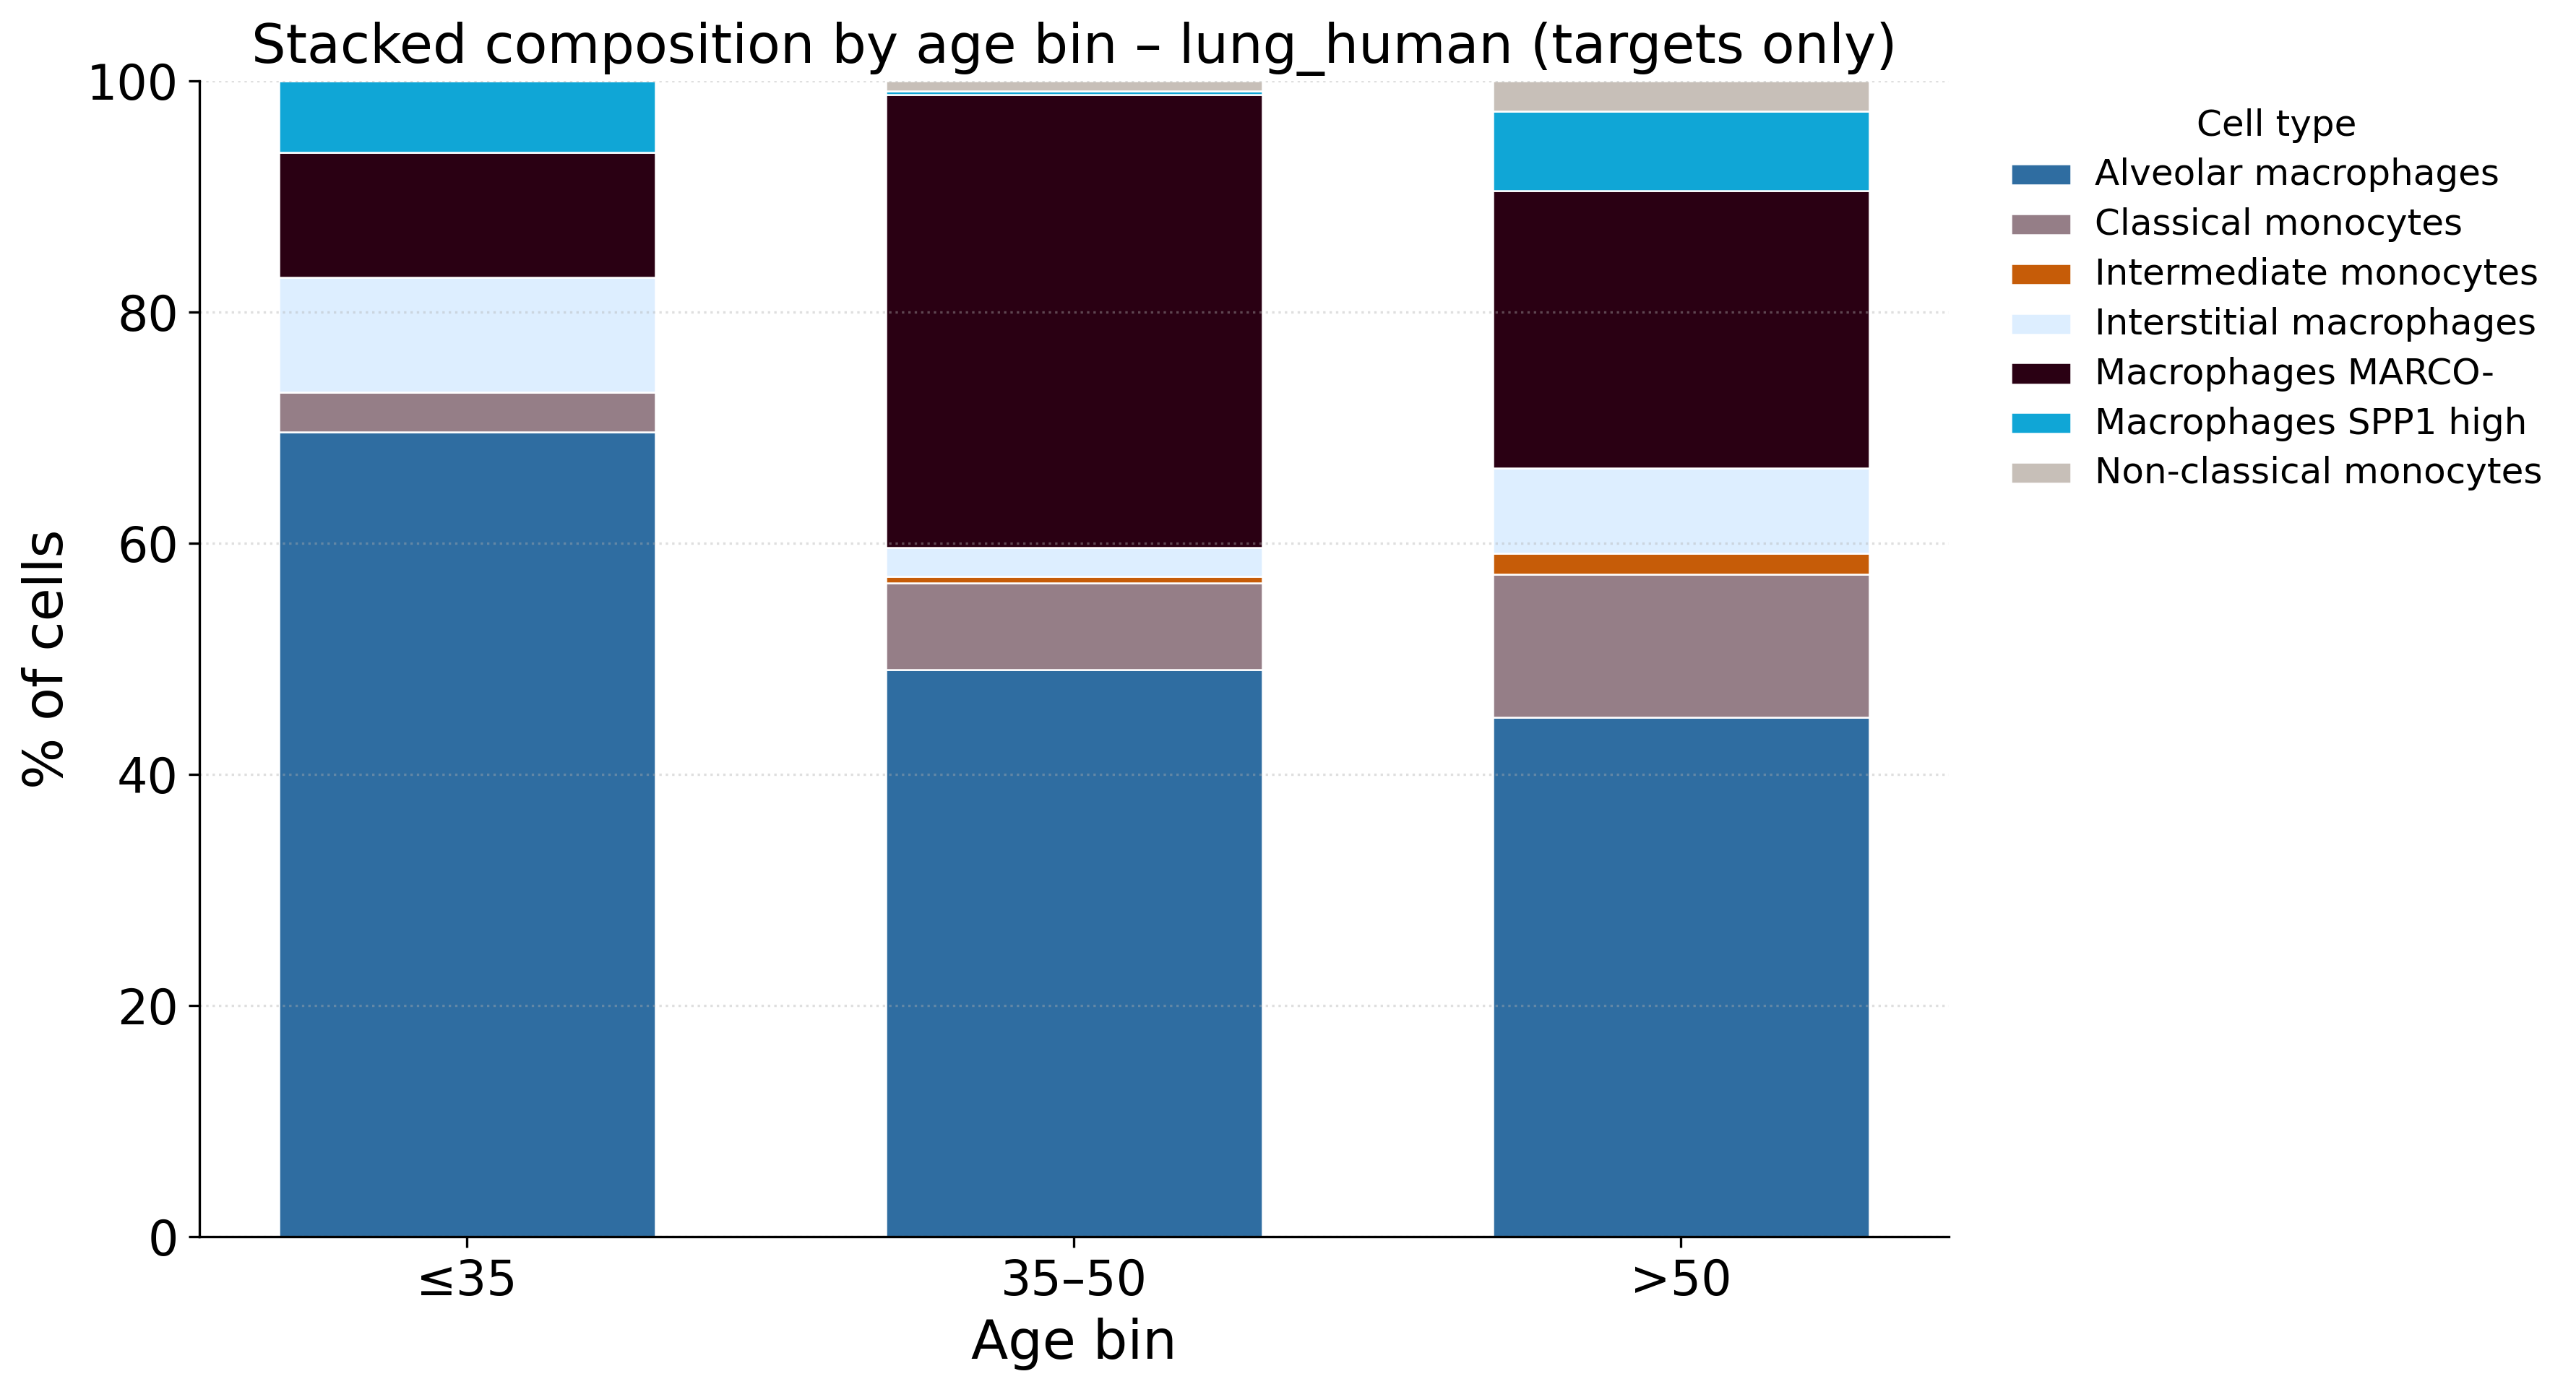

Saved:
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_grouped.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_facets.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_lines_all.png/.pdf
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_binned_props.csv
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_binned_stats.csv
  /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression_lung_human_stacked.png/.pdf


In [45]:
# ============================================
# Binned cell-type proportions (targets only)
# Palette control (AnnData or manual hex), CIs, stats, plots
# + stacked variants
# + single-panel "all lines" plot
# Font-size controls for axis labels & ticks
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest

# optional inline display (Jupyter)
try:
    from IPython.display import display, Image
    _HAS_IPY = True
except Exception:
    _HAS_IPY = False

# ---- defaults ----
DEFAULT_CELLTYPE_COL = "original_ann_level_4"
DEFAULT_AGE_FIELD    = "age_or_mean_of_age_range"
FIG_DPI = 300

# ---------- utils ----------
def _ensure_dir_for_file(path_no_ext: str):
    d = os.path.dirname(path_no_ext)
    if d:
        os.makedirs(d, exist_ok=True)

def _wilson_ci(k: int, n: int, alpha: float = 0.05):
    """Wilson binomial proportion CI."""
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    z = stats.norm.ppf(1 - alpha/2)
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half   = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

def get_palette_hex(adata, palette_col: str, label: str) -> str:
    s = adata.obs[palette_col].astype("category")
    cats = list(s.cat.categories)
    key = f"{palette_col}_colors"
    colors = list(adata.uns[key])
    return colors[cats.index(label)]

def _get_ct_colors(
    adata,
    col: str,
    subset: list[str],
    palette_col: str | None = None,
    overrides: dict | None = None,
) -> dict:
    """Build {celltype->color} using AnnData palette; fall back to Tab20*; apply overrides last."""
    base_col = palette_col or col
    key = f"{base_col}_colors"
    cmap = {}
    use_fallback = False

    if base_col in adata.obs.columns:
        s = adata.obs[base_col].astype("category")
        cats = list(s.cat.categories)
        if key in adata.uns and isinstance(adata.uns[key], (list, tuple)) and len(adata.uns[key]) == len(cats):
            colors = list(adata.uns[key])
            for ct in subset:
                if ct in cats:
                    cmap[ct] = colors[cats.index(ct)]
        elif key in adata.uns and isinstance(adata.uns[key], dict):
            paldict = adata.uns[key]
            for ct in subset:
                if ct in paldict:
                    cmap[ct] = paldict[ct]
                elif ct in cats and str(cats.index(ct)) in paldict:
                    cmap[ct] = paldict[str(cats.index(ct))]
            use_fallback = len(cmap) < len(subset)
        else:
            use_fallback = True
    else:
        use_fallback = True

    if use_fallback:
        pal = (list(plt.cm.get_cmap("tab20").colors)
             + list(plt.cm.get_cmap("tab20b").colors)
             + list(plt.cm.get_cmap("tab20c").colors))
        for i, ct in enumerate(subset):
            cmap[ct] = pal[i % len(pal)]

    if overrides:
        cmap.update({k: overrides[k] for k in overrides if k in subset})
    return cmap

# ---------- core computations ----------
def compute_binned_proportions(
    adata,
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str    = DEFAULT_AGE_FIELD,
    targets: list[str] | None = None,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
) -> pd.DataFrame:
    """
    Returns columns:
      age_bin, celltype, successes, trials, prop, ci_low, ci_high
    successes=#target cells/bin; trials=#all cells/bin; prop=successes/trials
    """
    if not targets:
        raise ValueError("Please pass a non-empty list of target cell types.")

    obs = adata.obs[[celltype_col, age_field]].copy()
    obs[age_field] = pd.to_numeric(obs[age_field], errors="coerce")
    obs = obs.dropna(subset=[age_field])

    obs["age_bin"] = pd.cut(
        obs[age_field].astype(float),
        bins=list(bin_edges),
        labels=list(bin_labels),
        right=True,
        include_lowest=True,
    )

    present_targets = [t for t in targets if t in obs[celltype_col].unique()]
    if not present_targets:
        raise ValueError("None of the target cell types are present after filtering ages.")

    # successes among targets
    df_t = obs[obs[celltype_col].isin(present_targets)].copy()
    k = (df_t.groupby(["age_bin", celltype_col]).size()
           .rename("successes").reset_index())

    # trials among ALL cells
    n = (obs.groupby("age_bin").size()
           .rename("trials").reset_index())

    out = k.merge(n, on="age_bin", how="left")
    out["prop"] = out["successes"] / out["trials"].replace(0, np.nan)

    ci = out.apply(lambda r: _wilson_ci(int(r["successes"]), int(r["trials"]), alpha=alpha), axis=1)
    out["ci_low"]  = [c[0] for c in ci]
    out["ci_high"] = [c[1] for c in ci]

    out = out.rename(columns={celltype_col: "celltype"})
    out["age_bin"] = pd.Categorical(out["age_bin"], categories=list(bin_labels), ordered=True)
    out = out[out["celltype"].isin(present_targets)]
    out = out.sort_values(["age_bin", "celltype"]).reset_index(drop=True)
    return out

def test_pairwise_bin_differences(props_df: pd.DataFrame, fdr_method="fdr_bh") -> pd.DataFrame:
    """Pairwise two-proportion z-tests between bins per cell type."""
    bins = list(props_df["age_bin"].cat.categories)
    pairs = [(bins[0], bins[1]), (bins[0], bins[2]), (bins[1], bins[2])]
    rows = []
    for ct, g in props_df.groupby("celltype"):
        for b1, b2 in pairs:
            r1 = g[g["age_bin"] == b1]; r2 = g[g["age_bin"] == b2]
            if r1.empty or r2.empty:
                continue
            k1, n1 = int(r1["successes"].iloc[0]), int(r1["trials"].iloc[0])
            k2, n2 = int(r2["successes"].iloc[0]), int(r2["trials"].iloc[0])
            if n1 == 0 or n2 == 0:
                stat, pval = (np.nan, np.nan)
            else:
                stat, pval = proportions_ztest([k1, k2], [n1, n2])
            p1 = k1 / (n1 if n1 > 0 else np.nan)
            p2 = k2 / (n2 if n2 > 0 else np.nan)
            rows.append({
                "celltype": ct, "bin1": str(b1), "bin2": str(b2),
                "k1": k1, "n1": n1, "p1": p1,
                "k2": k2, "n2": n2, "p2": p2,
                "diff": p2 - p1,
                "log2fc": np.log2((p2 + 1e-12)/(p1 + 1e-12)),
                "z": stat, "pval": pval
            })
    stats_df = pd.DataFrame(rows)
    if not stats_df.empty:
        stats_df["pval_adj"] = multipletests(stats_df["pval"].values, method=fdr_method)[1]
    return stats_df

# ---------- plotting ----------
def plot_grouped_bars(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    targets: list[str],
    title_prefix: str = "Binned proportions",
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    width_factor: float = 0.55,   # narrower bars (0..1)
    # NEW font controls
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
    legend_fs: float = 11,
):
    """Grouped bars with Wilson CIs. Bars narrower via width_factor."""
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = [ct for ct in targets if ct in props_df["celltype"].unique()]
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=celltypes,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    w_base = 0.8 / max(len(celltypes), 1)
    w = min(w_base, 0.12) * float(width_factor)
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    for i, ct in enumerate(celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y, lo, hi = sub["prop"].values, sub["ci_low"].values, sub["ci_high"].values
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)  # enforce lo<=y<=hi
        yplot = np.nan_to_num(y * factor, nan=0.0)
        err = np.vstack([
            np.nan_to_num(np.clip(y - lo, 0, None) * factor, nan=0.0),
            np.nan_to_num(np.clip(hi - y, 0, None) * factor, nan=0.0)
        ])
        xpos = x + (i - len(celltypes)/2) * w_base + w_base/2
        ax.bar(xpos, yplot, width=w, color=cmap.get(ct), label=ct,
               alpha=0.9, edgecolor="white", linewidth=0.6)
        ax.errorbar(xpos, yplot, yerr=err, fmt="none", ecolor="black",
                    elinewidth=1.0, capsize=3, alpha=0.9)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion", fontsize=axis_label_fs)
    ax.set_xlabel("Age bin", fontsize=axis_label_fs)
    ax.set_title(title_prefix, fontsize=title_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    if leg: 
        leg.set_title("Cell type")
        for txt in leg.get_texts(): txt.set_fontsize(legend_fs)
        leg.get_title().set_fontsize(legend_fs)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    png = out_base + "_grouped.png"; pdf = out_base + "_grouped.pdf"
    fig.savefig(pdf, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=png))

def plot_faceted_lines(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    targets: list[str],
    title_prefix: str = "Binned proportions – per cell type",
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    facet_linewidth: float = 3.0,
    facet_markers: bool = False,
    facet_markersize: float = 5.0,
    facet_whisker_width: float = 2.0,
    # NEW font controls
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
):
    """Per-cell-type small multiples with CIs (markers optional)."""
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = [ct for ct in targets if ct in props_df["celltype"].unique()]
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=celltypes,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0
    n = len(celltypes); cols = min(3, n); rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5.4*cols, 4.2*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax, ct in zip(axes, celltypes):
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y  = sub["prop"].values * factor
        lo = sub["ci_low"].values * factor
        hi = sub["ci_high"].values * factor
        lo = np.minimum(lo, y); hi = np.maximum(hi, y)
        err_low  = np.nan_to_num(np.clip(y - lo, 0, None), nan=0.0)
        err_high = np.nan_to_num(np.clip(hi - y, 0, None), nan=0.0)

        color = cmap.get(ct)
        marker = 'o' if facet_markers else None
        ax.plot(x, np.nan_to_num(y, nan=0.0),
                "-", linewidth=facet_linewidth, marker=marker,
                markersize=(facet_markersize if facet_markers else 0),
                color=color)
        for xi, yy, el, eh in zip(x, y, err_low, err_high):
            ax.vlines([xi], yy - el, yy + eh, color=color, linewidth=facet_whisker_width)

        ax.set_title(ct, fontsize=title_fs)
        ax.grid(True, linestyle=":", alpha=0.35)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", labelsize=tick_fs)

    for ax in axes[len(celltypes):]:
        ax.axis("off")
    for ax in axes[-cols:]:
        ax.set_xticks(x); ax.set_xticklabels(bins); ax.set_xlabel("Age bin", fontsize=axis_label_fs)
    for r in range(0, len(axes), cols):
        axes[r].set_ylabel("% of cells" if as_percent else "Proportion", fontsize=axis_label_fs)

    fig.suptitle(title_prefix, y=1.02, fontsize=title_fs + 1)
    fig.tight_layout()
    _ensure_dir_for_file(out_base)
    png = out_base + "_facets.png"; pdf = out_base + "_facets.pdf"
    fig.savefig(pdf, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=png))

def plot_all_lines_one_panel(
    props_df: pd.DataFrame,
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    as_percent: bool = True,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    show: bool = False,
    linewidth: float = 4.5,
    include_markers: bool = True,
    markersize: float = 6.5,
    # NEW font controls
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
    legend_fs: float = 11,
):
    """Single panel with all targets together (thick lines; markers optional)."""
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    celltypes = [ct for ct in targets if ct in props_df["celltype"].unique()]
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=celltypes,
                          palette_col=palette_col, overrides=color_overrides)
    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    for ct in celltypes:
        sub = props_df[props_df["celltype"] == ct].set_index("age_bin").reindex(bins)
        y = sub["prop"].values * factor
        marker = 'o' if include_markers else None
        ax.plot(x, np.nan_to_num(y, nan=0.0), "-",
                linewidth=linewidth, marker=marker,
                markersize=(markersize if include_markers else 0),
                color=cmap.get(ct), label=ct, alpha=0.95)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion", fontsize=axis_label_fs)
    ax.set_xlabel("Age bin", fontsize=axis_label_fs)
    ax.set_title(f"Binned proportions (single panel) – {tissue} (targets only)", fontsize=title_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    if leg:
        for txt in leg.get_texts(): txt.set_fontsize(legend_fs)
        leg.get_title().set_fontsize(legend_fs)
    ax.grid(True, linestyle=":", alpha=0.35)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    fig.tight_layout()
    base = f"{out_base}_{tissue}_lines_all"
    _ensure_dir_for_file(base)
    fig.savefig(base + ".pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(base + ".png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=base + ".png"))

# ---------- stacked variants ----------
def _pivot_props_for_stacking(props_df, targets):
    """Pivot to bins × targets, normalize rows to 1.0."""
    props_df = props_df[props_df["celltype"].isin(targets)].copy()
    bins = list(props_df["age_bin"].cat.categories)
    cols = [ct for ct in targets if ct in props_df["celltype"].unique()]
    pivot = (
        props_df.pivot_table(index="age_bin", columns="celltype", values="prop", fill_value=0.0)
                .reindex(index=bins)
                .reindex(columns=cols)
                .fillna(0.0)
    )
    row_sums = pivot.sum(axis=1).replace(0, np.nan)
    pivot = pivot.div(row_sums, axis=0).fillna(0.0)
    return pivot

def plot_stacked_bars(
    props_df,
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    as_percent: bool = True,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    show: bool = False,
    bar_width: float = 0.62,
    # NEW font controls
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
    legend_fs: float = 11,
):
    """100% stacked bars per age bin (only targets)."""
    pivot = _pivot_props_for_stacking(props_df, targets)
    bins = list(pivot.index)
    cols = list(pivot.columns)
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=cols,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    factor = 100.0 if as_percent else 1.0

    fig, ax = plt.subplots(figsize=(12, 6.5))
    bottom = np.zeros(len(bins), dtype=float)
    for ct in cols:
        y = pivot[ct].values * factor
        ax.bar(x, y, bottom=bottom, width=bar_width,
               color=cmap.get(ct), edgecolor="white", linewidth=0.6, label=ct)
        bottom += y

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("% of cells" if as_percent else "Proportion", fontsize=axis_label_fs)
    ax.set_xlabel("Age bin", fontsize=axis_label_fs)
    ax.set_ylim(0, 100 if as_percent else 1.0)
    ax.set_title(f"Stacked composition by age bin – {tissue} (targets only)", fontsize=title_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    if leg:
        for txt in leg.get_texts(): txt.set_fontsize(legend_fs)
        leg.get_title().set_fontsize(legend_fs)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    fig.tight_layout()
    base = f"{out_base}_{tissue}_stacked"
    _ensure_dir_for_file(base)
    fig.savefig(base + ".pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(base + ".png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=base + ".png"))

def plot_stacked_area(
    props_df,
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    show: bool = False,
    stacked_area_edge_lw: float = 0.0,
    # NEW font controls
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
    legend_fs: float = 11,
):
    """Stacked area (same data as bars)."""
    pivot = _pivot_props_for_stacking(props_df, targets)
    bins = list(pivot.index)
    cols = list(pivot.columns)
    cmap = _get_ct_colors(adata, DEFAULT_CELLTYPE_COL, subset=cols,
                          palette_col=palette_col, overrides=color_overrides)

    x = np.arange(len(bins))
    colors = [cmap[c] for c in cols]

    fig, ax = plt.subplots(figsize=(12, 6.5))
    ax.stackplot(x, pivot.values.T, labels=cols, colors=colors, linewidth=stacked_area_edge_lw)

    ax.set_xticks(x); ax.set_xticklabels(bins)
    ax.set_ylabel("Proportion", fontsize=axis_label_fs)
    ax.set_xlabel("Age bin", fontsize=axis_label_fs)
    ax.set_ylim(0, 1.0)
    ax.set_title(f"Stacked area by age bin – {tissue} (targets only)", fontsize=title_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False, title="Cell type")
    if leg:
        for txt in leg.get_texts(): txt.set_fontsize(legend_fs)
        leg.get_title().set_fontsize(legend_fs)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    fig.tight_layout()
    base = f"{out_base}_{tissue}_stacked_area"
    _ensure_dir_for_file(base)
    fig.savefig(base + ".pdf", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    fig.savefig(base + ".png", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.10)
    plt.close(fig)
    if show and _HAS_IPY:
        display(Image(filename=base + ".png"))

# ---------- wrapper ----------
def make_binned_plots_and_stats(
    adata,
    out_base: str,
    tissue: str,
    targets: list[str],
    celltype_col: str = DEFAULT_CELLTYPE_COL,
    age_field: str = DEFAULT_AGE_FIELD,
    bin_edges = (-np.inf, 35, 50, np.inf),
    bin_labels = ("≤35", "35–50", ">50"),
    alpha: float = 0.05,
    as_percent: bool = True,
    show: bool = False,
    palette_col: str | None = None,
    color_overrides: dict | None = None,
    width_factor: float = 0.55,           # grouped bars width factor
    make_stacked: bool = False,
    make_stacked_area_plot: bool = False,
    make_all_lines_one_panel: bool = True,
    # line/marker knobs:
    all_lines_linewidth: float = 4.5,
    all_lines_markers: bool = True,
    all_lines_markersize: float = 6.5,
    facet_linewidth: float = 3.0,
    facet_markers: bool = False,
    facet_markersize: float = 5.0,
    facet_whisker_width: float = 2.0,
    stacked_area_edge_lw: float = 0.0,
    # NEW font controls (threaded to all plots)
    axis_label_fs: float = 16,
    tick_fs: float = 13,
    title_fs: float = 16,
    legend_fs: float = 11,
):
    """Compute props; grouped bars + facets; optional stacked; optional all-lines plot; stats."""
    props = compute_binned_proportions(
        adata,
        celltype_col=celltype_col,
        age_field=age_field,
        targets=targets,
        bin_edges=bin_edges,
        bin_labels=bin_labels,
        alpha=alpha,
    )

    title = f"Binned proportions – {tissue} (targets only; normalized by total cells per bin)"
    base = f"{out_base}_{tissue}"

    plot_grouped_bars(
        props, adata, out_base=base, targets=targets,
        title_prefix=title, as_percent=as_percent, show=show,
        palette_col=palette_col, color_overrides=color_overrides,
        width_factor=width_factor,
        axis_label_fs=axis_label_fs, tick_fs=tick_fs, title_fs=title_fs, legend_fs=legend_fs
    )
    plot_faceted_lines(
        props, adata, out_base=base, targets=targets,
        title_prefix=f"{title} – per cell type", as_percent=as_percent, show=show,
        palette_col=palette_col, color_overrides=color_overrides,
        facet_linewidth=facet_linewidth, facet_markers=facet_markers,
        facet_markersize=facet_markersize, facet_whisker_width=facet_whisker_width,
        axis_label_fs=axis_label_fs, tick_fs=tick_fs, title_fs=title_fs
    )
    if make_all_lines_one_panel:
        plot_all_lines_one_panel(
            props, adata, out_base=out_base, tissue=tissue, targets=targets,
            as_percent=as_percent, palette_col=palette_col,
            color_overrides=color_overrides, show=show,
            linewidth=all_lines_linewidth, include_markers=all_lines_markers,
            markersize=all_lines_markersize,
            axis_label_fs=axis_label_fs, tick_fs=tick_fs, title_fs=title_fs, legend_fs=legend_fs
        )
    if make_stacked:
        plot_stacked_bars(
            props, adata, out_base=out_base, tissue=tissue, targets=targets,
            as_percent=as_percent, palette_col=palette_col,
            color_overrides=color_overrides, show=show, bar_width=0.62,
            axis_label_fs=axis_label_fs, tick_fs=tick_fs, title_fs=title_fs, legend_fs=legend_fs
        )
    if make_stacked_area_plot:
        plot_stacked_area(
            props, adata, out_base=out_base, tissue=tissue, targets=targets,
            palette_col=palette_col, color_overrides=color_overrides, show=show,
            stacked_area_edge_lw=stacked_area_edge_lw,
            axis_label_fs=axis_label_fs, tick_fs=tick_fs, title_fs=title_fs, legend_fs=legend_fs
        )

    stats_df = test_pairwise_bin_differences(props)

    _ensure_dir_for_file(out_base)
    props.to_csv(base + "_binned_props.csv", index=False)
    stats_df.to_csv(base + "_binned_stats.csv", index=False)
    print(f"Saved:\n  {base}_grouped.png/.pdf\n  {base}_facets.png/.pdf\n  {base}_lines_all.png/.pdf"
          f"\n  {base}_binned_props.csv\n  {base}_binned_stats.csv")
    if make_stacked:
        print(f"  {out_base}_{tissue}_stacked.png/.pdf")
    if make_stacked_area_plot:
        print(f"  {out_base}_{tissue}_stacked_area.png/.pdf")
    return props, stats_df

# -------------------------
# Example usage (uncomment/edit and run to regenerate)
# -------------------------
targets = [
    "Alveolar macrophages",
    "Classical monocytes",
    "Intermediate monocytes",
    "Interstitial macrophages",
    "Macrophages MARCO-",
    "Macrophages SPP1 high",
    "Non-classical monocytes",
]
overrides = {
    "Classical monocytes": "#957E87",
    "Alveolar macrophages": "#2F6DA1",
    "Intermediate monocytes": "#C65C08",
    "Interstitial macrophages":"#DDEEFF",
    "Macrophages MARCO-":"#2A0013",
    "Macrophages SPP1 high":"#10A6D6",
    "Non-classical monocytes":"#C7BFB8",
}
props, stats_df = make_binned_plots_and_stats(
    adata,
    out_base="/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/cell-cell-communication-liana/lung-human/test4-lsregression",
    tissue="lung_human",
    targets=targets,
    celltype_col="original_ann_level_4",
    age_field="age_or_mean_of_age_range",
    palette_col="original_ann_level_4",
    color_overrides=overrides,
    show=True,
    as_percent=True,
    width_factor=0.5,                 # slimmer grouped bars
    make_stacked=True,
    make_stacked_area_plot=False,
    make_all_lines_one_panel=True,
    # line/marker knobs:
    all_lines_linewidth=5.0,
    all_lines_markers=True,           # circles ON
    all_lines_markersize=7.0,
    facet_linewidth=3.5,
    facet_markers=True,               # circles ON in facets
    facet_markersize=7.0,
    facet_whisker_width=2.2,
    # font sizes:
    axis_label_fs=18,                 # bigger x/y labels
    tick_fs=16,                       # bigger tick text
    title_fs=18,
    legend_fs=12,
)
